In [1]:
import numpy as np
from graph_tool.all import *
from scipy.stats import expon as expon
from scipy.stats import poisson as pois
from scipy.stats import zipf as zipf_distr
from scipy.stats import norm as snorm
import matplotlib as plt
import graph_tool.generation as gt
from copy import deepcopy as cp
from scipy import integrate as integr
import time
import scipy
import itertools
%pylab inline

/usr/local/lib/python2.7/site-packages/graph_tool/draw/cairo_draw.py:1453: PyGIWarning: Gtk was imported without specifying a version first. Use gi.require_version('Gtk', '3.0') before import to ensure that the right version gets loaded.
  from gi.repository import Gtk, Gdk, GdkPixbuf

Populating the interactive namespace from numpy and matplotlib


pylab import has clobbered these variables: ['plt', 'show_config']
`%matplotlib` prevents importing * from pylab and numpy


In [ ]:
?integr.odeint

In [ ]:
def solvr(Y, t):
    return [Y[1], -2 * Y[0]-Y[1]]

In [ ]:
a_t = np.arange(0, 25.0, 0.01)
asol = integr.odeint(solvr, [1, 0], a_t)

In [ ]:
def solvr(Y, t):
    return t

In [ ]:
a_t = np.arange(1, 10, 0.01)
sol = integr.odeint(solvr, 50, a_t)
plt.plot(a_t, sol)

# Надо сделать:
-Научиться генерировать граф с заданным распределением на степени вершин - ОК    
-Дать каждой вершине +1 или -1 с заданными долями в зависимости от степени, или случайно - ОК   
-Визуализировать текущую ситуацию - ОК   
-Сделать шаг пересчета - ОК  
-Написать функцию для вычисления среднего поля и парных корелляций - ОК  
-Разбить вершины по квантилям на 3 группы в зависимости от степени - ОК  
-Написать генерацию степеней для пуассоновского распределения и степенного для k - параметр - ОК    
-Написать реализацию пуассоновских часов - ОК   
-Найти начиная с какого количества ребер происходит сходимость всех к одной стороне  
-Найти зависимость сходимости от $\sigma$ в нормальном распределении для разности шума  
-Переделать F для разности двух гауссовых распределений - ОК    
-Найти зависимость сходимости от $\sigma$ для конкретных графов двух типов

# 1. Основные функции

## 1.1 Функция распределения степеней вершин

In [2]:
def get_vertex_degree():
    if GTYPE == 'pois':
        return pois.rvs(SIZE*0.1, 0, 1)[0]
    if GTYPE == 'randint':
        return np.random.randint(10)
    if GTYPE == 'zipf':
        return zipf_distr.rvs(2.5, loc=0, size=1, random_state=None)[0]

## 1.2 Функция генерации графа

In [3]:
def gen_graph():
    g = gt.random_graph(SIZE, get_vertex_degree, directed=False)
    labels = g.new_vertex_property("int")
    weighted_total = g.new_graph_property("vector<double>")
    revise_times = g.new_graph_property("vector<double>")
    k_mean = g.new_graph_property("double")
    
    g.vertex_properties["labels"] = labels
    g.graph_properties["m_w"] = weighted_total
    g.graph_properties["times"] = revise_times
    g.graph_properties["k_mean"] = k_mean
    
#    labels_mean = g.new_vertex_property("vector<int>")  
    vertices = [item for item in g.vertices()]
    
    # начальное распределение на вершины
    for vertex in vertices:
        labels[vertex] = np.random.binomial(1, 0.5, 1) * 2 - 1
#        labels_mean[vertex].append(0)
    # среднее значение степени вершины
    k_mean[g] = np.mean([g.degree_property_map('out')[v] for v in g.vertices()])
    revise_times[g].append(0)
    weight = 1.0 * np.sum([labels[v]*g.degree_property_map('out')[v] for v in g.vertices()])
    weight /= SIZE
    weight /= k_mean[g]
    weighted_total[g].append(weight)
    
    pos = graph_tool.draw.sfdp_layout(g)
    
    return g, pos

## 1.3 Инициализирующие параметры и начальный граф

In [4]:
SIZE = 500
GTYPE = 'zipf'
g, _ = gen_graph()
vert_degrees = np.array([g.degree_property_map('out')[v] for v in g.vertices()])

In [33]:
res = np.unique(vert_degrees)
print res

[  1   2   3   4   5   7   8   9  10  11  12  13  14  41  45  54 173]


In [175]:
SIZE = 500
GTYPE = 'pois'
g, _ = gen_graph()

## 1.4 Функция для вычисления порядка в котором агенты пересматривают свои решения.
##### Вход:  
-суммарное количество агентов  
-суммарное количество пересмотров  
##### Выход:
-список из агентов в порядке очереди пересчета и времена пересчетов

In [5]:
def get_queue(revisions_number, agents_number=SIZE):
    k = int(revisions_number / agents_number) + 1
    calc_times = expon.rvs(size = agents_number*k)
    
    pairs_time_number = [[calc_times[i], i] for i in range(agents_number)]
    for j in range(k-1):
        l = [[calc_times[i+j*agents_number] + pairs_time_number[i + j*agents_number][0], i] for i in range(agents_number)]
        pairs_time_number += l
    
    pairs_time_number.sort()
    
    queue = [pairs_time_number[i][1] for i in range(revisions_number)]
    calc_times = [pairs_time_number[i][0] for i in range(revisions_number)]
    return queue, calc_times

In [103]:
get_queue(10, 3)

([0, 1, 0, 1, 2, 1, 1, 0, 2, 2],
 [0.13266662332897303,
  0.15068368216240474,
  0.26533324665794605,
  0.30136736432480948,
  1.0918299743176407,
  1.2001430441746281,
  1.5396897798124025,
  2.0750216762692024,
  2.1836599486352815,
  2.7818636758672071])

## 1.5 Функция распределения для $\varepsilon(1) - \varepsilon(-1)$

Каждая $\varepsilon$ распределена нормально, значит $\varepsilon(1) - \varepsilon(-1) = \varepsilon(1) + (- \varepsilon(-1))$$. Сумма двух нормальных величин - нормальная величина с суммарной дисперсией

In [6]:
def cdf(delta_utility):
    return snorm.cdf(delta_utility, loc=0.0, scale=5)

## 1.6 Функция для обновления меток на основании полезности

Переходная условная вероятность имеет вид  
$P(w_{it+} = 1| w_t) = F(2h + 2 \frac{J}{I-1} \sum\limits_{j \ne i} w_{jt}$), где   
$w_{it+}$ - выбор $i$-того агента в момент времени $t+1$  
$2h$ - коэффициент индивидуальной полезности, в программе $private \text{ } utility$  
$2 \frac{J}{I-1}$ - коэффициент полезности соответствия соседям, в программе $pairwise \text{ } utitily$  

In [7]:
def revise_label(agent_number, time, g=g, size=SIZE, cdf=cdf):
    private_utility = 0.0
    pairwise_utitily = 1.0
    v = g.vertex(agent_number)
    labels = g.vertex_properties["labels"]
    g.graph_properties["times"].append(time)
    prev_label = labels[v]
        
    neighbours = [item for item in v.out_neighbours()]
    neighbours_sum = np.sum([labels[v_neighb] for v_neighb in neighbours])
    prob = cdf(private_utility + pairwise_utitily*neighbours_sum)
    
    labels[v] = np.random.binomial(1, prob, 1) * 2 - 1
    
    delta_m_w = 1.0*(labels[v] - prev_label) * g.degree_property_map('out')[v] / g.graph_properties["k_mean"] / size
    g.graph_properties["m_w"].append(g.graph_properties["m_w"][-1] + delta_m_w)
#    labels_mean[v].append(2*prob - 1)

## 1.7 Функция для вычисления текущего среднего поля и парных корелляций

Функция разбивает вершины в зависимости от степени на $k$ групп (по квантилям) и возвращает пару из массива средних значений меток длины $k$ и матрицу парных корреляций размера $k*k$

In [8]:
def calc_cur_stats(k=3, g=g):
    # параллельные списки из меток и степеней вершин
    labels = g.vertex_properties["labels"]
    vert_labels = np.array([labels[v] for v in g.vertices()])
    vert_degrees = np.array([g.degree_property_map('out')[v] for v in g.vertices()])
    vert_groups = np.zeros(len(vert_degrees)+1)
    # Определяем границы для разделения вершин по степеням на k групп
    bounds = [-1.0]
    for i in range(k-1):
        bounds.append(np.percentile(vert_degrees, 100.0 * (i+1) / k))
    
    bounds.append(np.max(vert_degrees))
    
    # Задаем группы вершинам в зависимости от степени
    
    # Создаем итоговые статистики: Средние метки
    mean_fields = []
    for i in range(k):
        indexes = np.array(vert_degrees > bounds[i]) * np.array(vert_degrees <= bounds[i+1])
        # Задаем группы вершинам в зависимости от степени
        vert_groups[indexes] = i
        mean_fields.append(np.mean(vert_labels[indexes]))
#        print len(bounded_labels)

    # Создаем итоговые статистики: Средние парные корелляции
    pair_corr = dict()
    for i in range(k):
        for j in range(k):
            pair_corr[(i, j)] = []
    for edge in g.edges():
        matr_index = (vert_groups[int(edge.source())], vert_groups[int(edge.target())])
        matr_index_inv = (matr_index[1], matr_index[0])
        
        matr_value = vert_labels[int(edge.source())] * vert_labels[int(edge.target())]
        
        pair_corr[matr_index].append(matr_value)
        pair_corr[matr_index_inv].append(matr_value)
    
    pair_corr_matr = np.zeros((k, k))
    for i in range(k):
        for j in range(k):
            pair_corr_matr[i, j] = np.mean(pair_corr[(i, j)])
    return mean_fields, pair_corr_matr

# 2. Решения дифуров

## 2.1 Решение (37) для $m_w$

In [9]:
def g_func(x):
    return np.log(cdf(x)) - np.log(1 - cdf(x))

In [10]:
def derivative_m_w(m, t):
    vert_degrees = np.array([g.degree_property_map('out')[v] for v in g.vertices()])
    k_mean = np.mean(vert_degrees)
    k_max = np.max(vert_degrees)
    sum_k = 0
    for k in range(k_max + 1):
        p_k = 1.0 * np.sum(vert_degrees == k) / SIZE
        if (p_k != 0):
            koef = np.tanh(0.5*g_func(1.0*k*m))
            sum_k += k * p_k * koef
    sum_k /= k_mean
    return sum_k - m

In [11]:
def calc_start_m_w():
    labels = g.vertex_properties["labels"]
    vert_degrees = np.array([g.degree_property_map('out')[v] for v in g.vertices()])
    vert_labels = np.array([labels[v] for v in g.vertices()])
    k_mean = np.mean(vert_degrees)
    
    m_w = 0.0
    for i in range(len(vert_labels)):
        m_w += vert_degrees[i]*vert_labels[i]
    m_w /= SIZE
    m_w /= k_mean
    return m_w

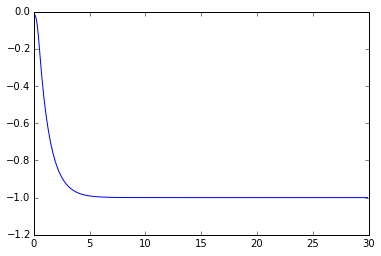

In [119]:
a_t = np.arange(0, 30, 0.1)
sol = integr.odeint(derivative_m_w, calc_start_m_w(), a_t)
plt.plot(a_t, sol)

## Функция для тестов

#### Принимает:  
-размер очереди (количество обновлений меток между замерами)  
-количество замеров  
-количество повторений тестов  
-на сколько частей делить вершины по степеням  
-измеряемый параметр (среднее поле\парные корреляции)

In [12]:
def test(queue_size, evo_points, test_number=5, parts_number=3, param='mean', cdf=cdf):
    for i in range(test_number):
        print "Start iteration ", i+1, " of ", test_number
        g, _ = gen_graph()
        
        res = []
        if param == 'mean':
            for j in range(parts_number+1):
                res.append([])
            for step in range(evo_points):
                queue, times = get_queue(queue_size, SIZE)
                for idx in range(len(queue)):
                    revise_label(queue[idx], times[idx], g, SIZE, cdf)
                temp, corr = calc_cur_stats(3, g=g)

                for j in range(len(temp)):
                    res[j].append(temp[j])
                res[3].append(np.mean(temp))

                
            xvalues = [queue_size * i for i in range(evo_points)]
            plt.figure(figsize = (15, 4))
            
            plt.plot(xvalues, res[0], label="low")
            plt.plot(xvalues, res[1], label="medium")
            plt.plot(xvalues, res[2], label="high")
        #    plt.plot(res[3], label="superHigh")
           
            plt.plot(xvalues, res[3], label="mean", color='black')
            plt.legend(loc='best')
            
    # Пока что реализация для parts_number = 3
        if param == 'corr':
            for j in range(6):
                res.append([])
            for step in range(evo_points):
                queue = get_queue(queue_size, SIZE)[0]
                for vert_index in queue:
                    revise_label(vert_index, g, SIZE, cdf)

                _, corr = calc_cur_stats(3, g=g)

                for i in range(3):
                    res[i].append(corr[i, i])

                res[3].append(corr[0, 1])
                res[4].append(corr[0, 2])
                res[5].append(corr[1, 2])

            figure(figsize = (15, 4))
            plt.plot(res[0], label="low_low")
            plt.plot(res[1], label="medium_medium")
            plt.plot(res[2], label="high_high")
            plt.legend(loc='best')

            figure(figsize = (15, 4))
            plt.plot(res[3], label="low_medium")
            plt.plot(res[4], label="low_high")
            plt.plot(res[5], label="medium_high")
            plt.legend(loc='best')

## Зависимость сходимости от $\sigma$ в нормальном распределении

In [ ]:
SIZE = 500
GTYPE = 'pois'

In [13]:
def test_stability(queue_size=10, evo_points=200, test_number=1, parts_number=3, eps = 0.01, cdf=cdf):
    g, _ = gen_graph()
    for i in range(test_number):
        print "Start iteration ", i+1, " of ", test_number
        g, _ = gen_graph()

        res = []
        for j in range(parts_number+1):
            res.append([])
        for step in range(evo_points):
            queue = get_queue(queue_size, SIZE)[0]
            for vert_index in queue:
                revise_label(vert_index, g, SIZE, cdf)
            temp, corr = calc_cur_stats(3, g=g)

            for j in range(len(temp)):
                res[j].append(temp[j])
            res[len(temp)].append(np.mean(temp))

        stables = [[],[],[]]
        for i in range(parts_number):
            for j in range(len(res[i])):
                if np.abs(res[i][j]) + eps > 1:
                    stables[i].append(np.sign(res[i][j]))
                else:
                    stables[i].append(0)

        for i in range(parts_number):
            for j in range(len(stables[i])):
                if (stables[i][j] != 0):
                    print "size = ", i, j, " first of ", len(stables[i]), "var after = ", np.var(stables[i][j:])
                    break

        figure(figsize = (15, 4))
        plt.plot(res[0], label="low")
        plt.plot(res[1], label="medium")
        plt.plot(res[2], label="high")

        plt.plot(res[3], label="mean", color='black')
        plt.legend(loc='best')

before stable =  0.958029110265 after stable =  1.79818249763
before stable =  0.175345656473 after stable =  0.0176817688891
before stable =  1.02601708995 after stable =  1.81992981492
before stable =  0.0305813682597 after stable =  0.013728351843
before stable =  0.17005758192 after stable =  0.0193405712568
before stable =  1.08375322342 after stable =  1.8097627693
before stable =  0.406924866859 after stable =  0.0347400036929
before stable =  0.781960333792 after stable =  1.28203549754
before stable =  0.0995693354891 after stable =  0.00821082520728
before stable =  0.982736423366 after stable =  1.79307883365


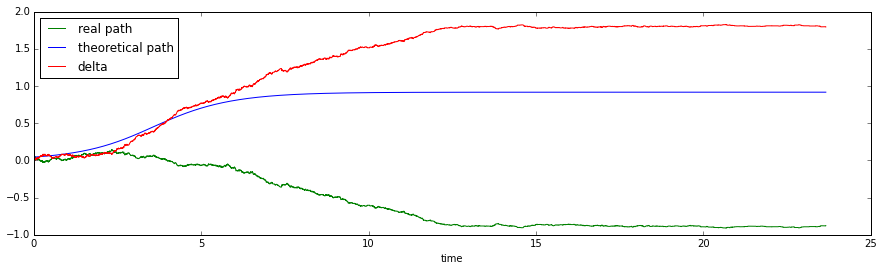

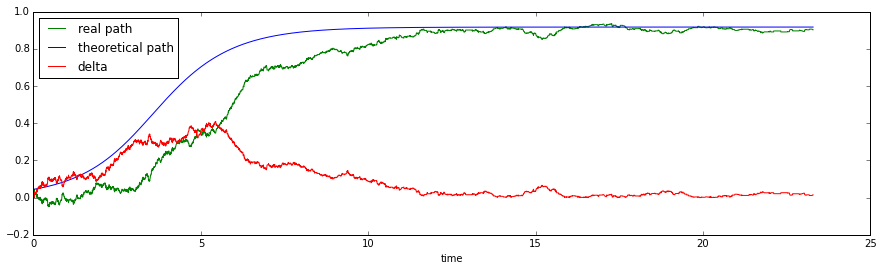

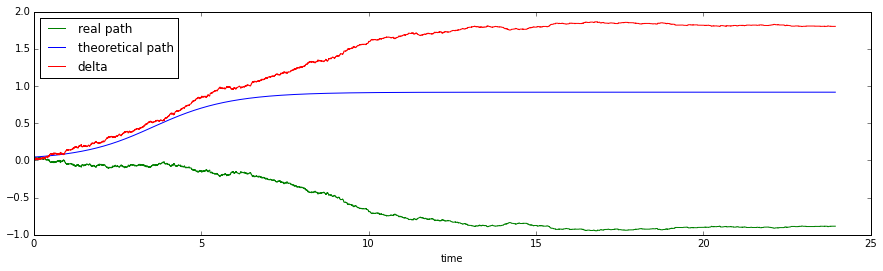

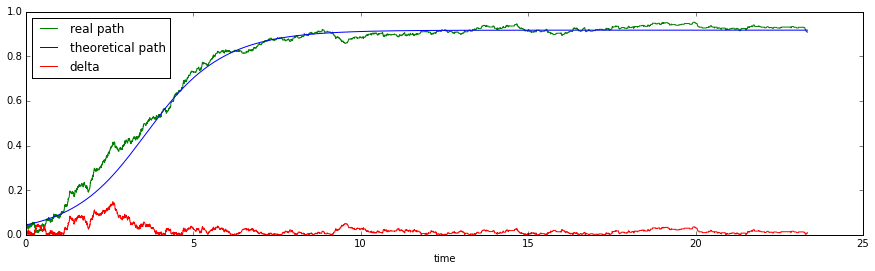

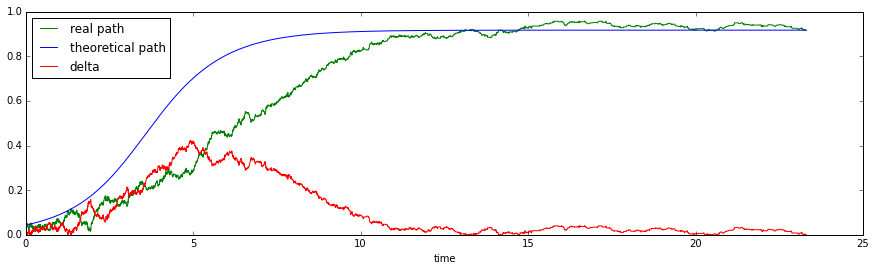

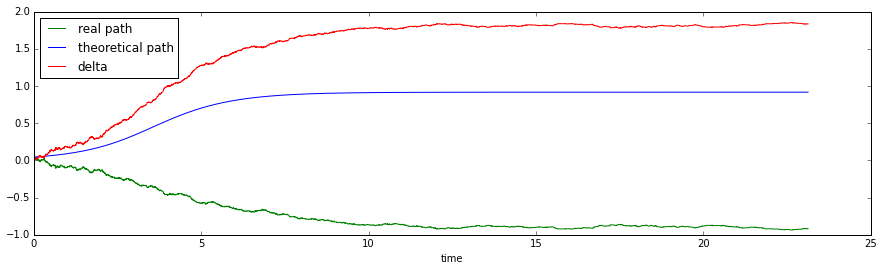

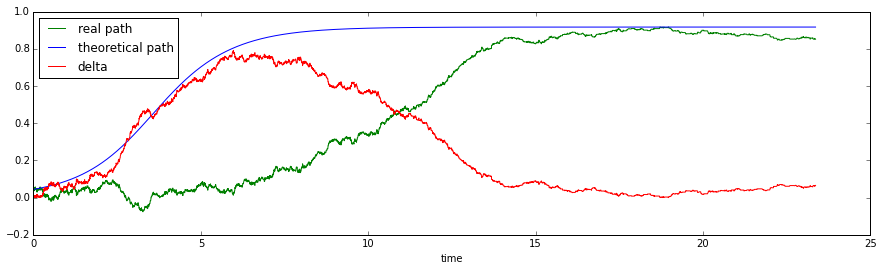

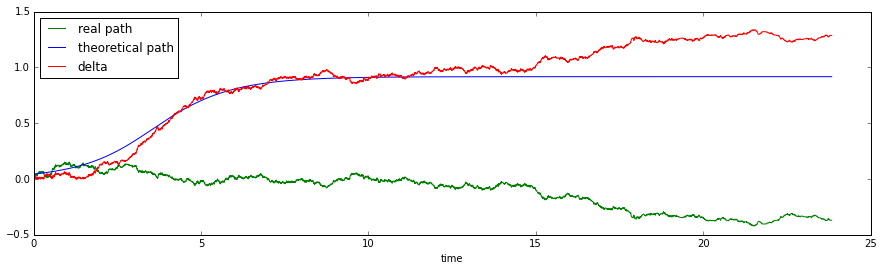

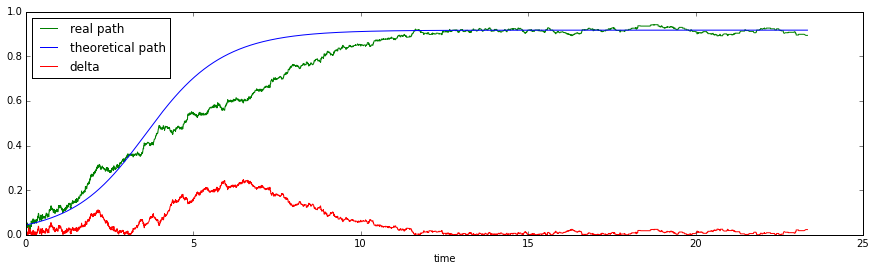

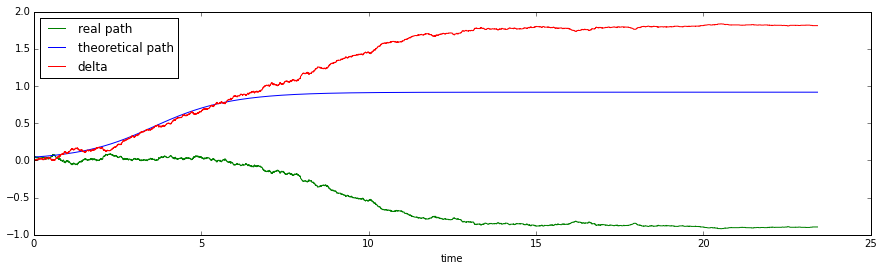

In [63]:
SIZE = 500
GTYPE = 'pois'
queue_size = 10000

def cdf(delta_utility):
    return snorm.cdf(delta_utility, loc=0.0, scale=5)
def get_vertex_degree():
    if GTYPE == 'pois':
        return pois.rvs(SIZE*0.02, 0, 1)[0]
    if GTYPE == 'randint':
        return np.random.randint(10)
    if GTYPE == 'zipf':
        return zipf_distr.rvs(2.5, loc=0, size=1, random_state=None)[0]
    
res_before = []
res_after = []

g, _ = gen_graph()
g_copy = cp(g)
for k in range(10):
    g = cp(g_copy)
    queue, times = get_queue(queue_size, SIZE)
    for i in range(len(queue)):
        revise_label(queue[i], times[i], g, SIZE, cdf)
    a_t = np.array(g.graph_properties["times"])

    real_path = np.array(g.graph_properties["m_w"])

    g = g_copy
    sol = integr.odeint(derivative_m_w, calc_start_m_w(), a_t)
    deltas = [abs(sol[i][0]-real_path[i]) for i in range(len(sol))]

    stable_i = 0
    smoothed = [1]*1000 + list([abs(np.mean(real_path[i:i+1000]) - np.mean(real_path[-1000:])) for i in range(len(real_path) - 1000)])
    for i in range(len(real_path)-1, 1000, -1):
        if smoothed[i] > 0.05:
            stable_i = i
            break
    res_before.append(np.mean(deltas[0: stable_i]))
    res_after.append(np.mean(deltas[stable_i:]))
    print "before stable = ", res_before[-1], "after stable = ", res_after[-1]      

    fig = plt.figure(figsize = (15, 4))
    ax = fig.add_subplot(111)
    ax.set_xlabel("time")

    ax.plot(a_t, real_path, color = "green", label="real path")
    ax.plot(a_t, sol, color = "blue", label="theoretical path")
    ax.plot(a_t, deltas, color = "red", label="delta")

    plt.legend(loc='best')


before stable =  0.10884530541 after stable =  0.0219634555148
before stable =  0.951805419815 after stable =  1.82011412812
before stable =  0.862360172336 after stable =  1.77933822867
before stable =  0.0955697139434 after stable =  0.0158003188029
before stable =  0.900681463619 after stable =  1.75672088871
before stable =  0.768834949585 after stable =  1.80533078896
before stable =  0.773387340558 after stable =  1.76916915462
before stable =  0.151425071186 after stable =  0.0122631131369
before stable =  0.143102360249 after stable =  0.0212150180433
before stable =  0.868963504595 after stable =  1.7984340449


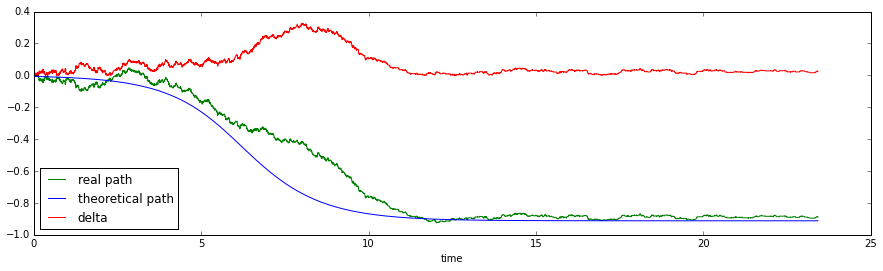

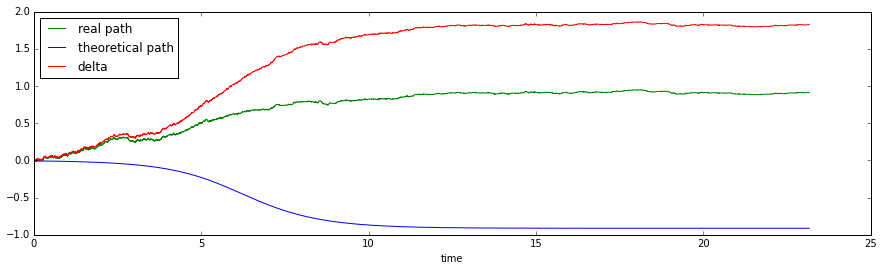

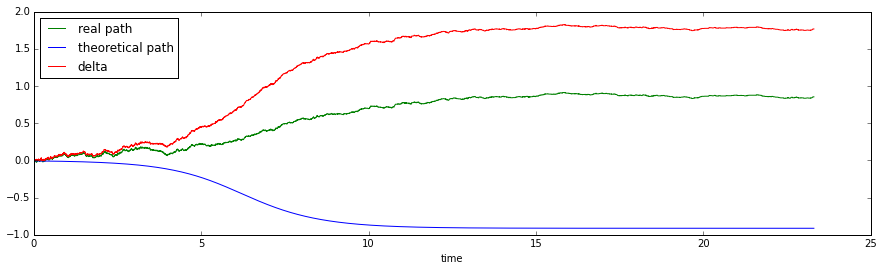

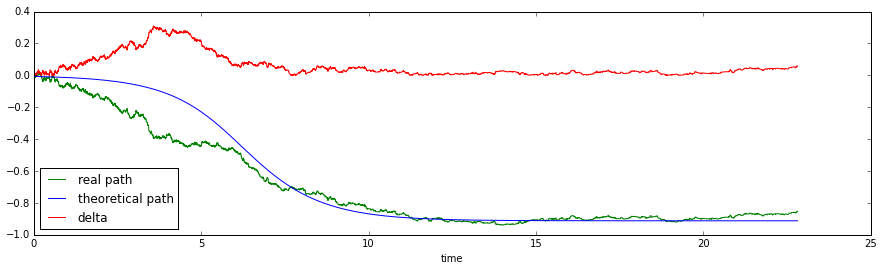

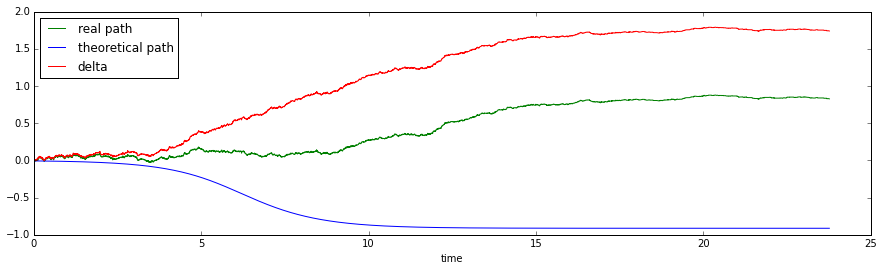

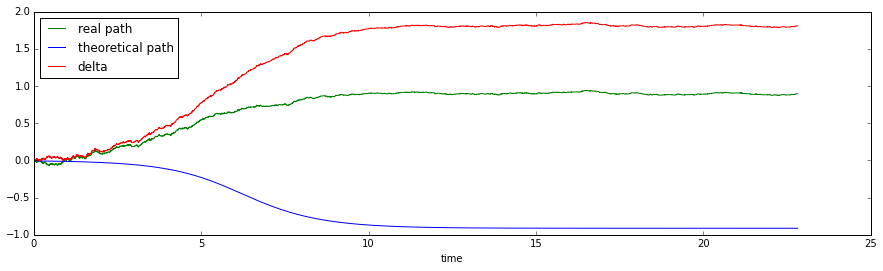

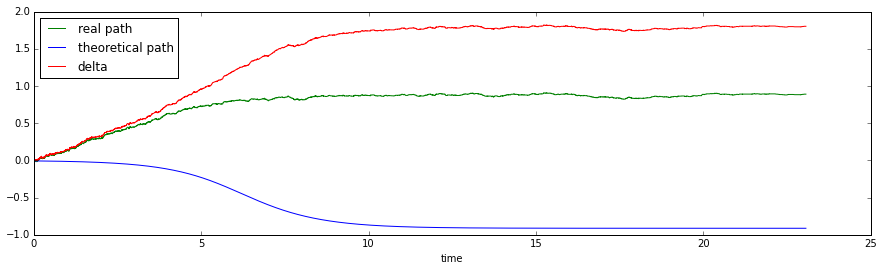

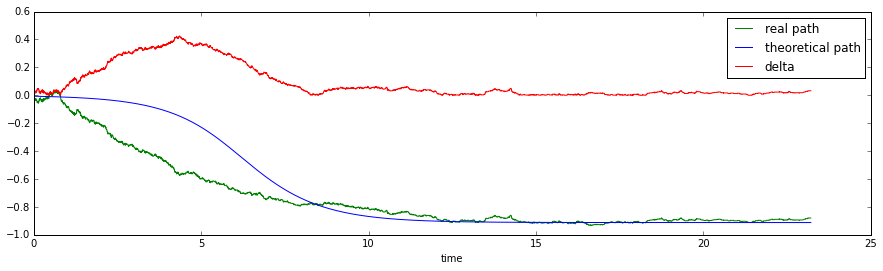

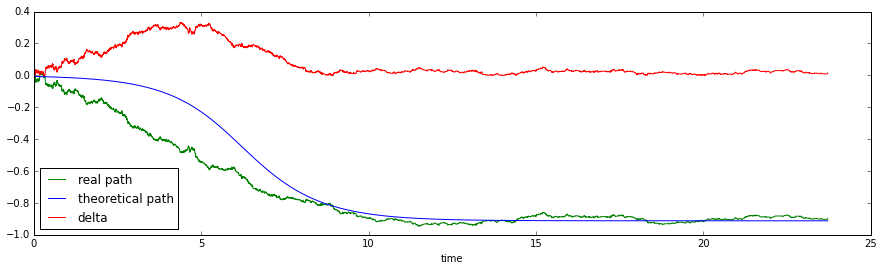

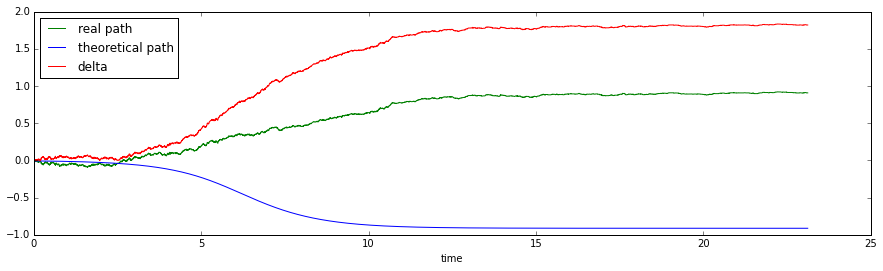

In [64]:
SIZE = 500
GTYPE = 'pois'
queue_size = 10000

def cdf(delta_utility):
    return snorm.cdf(delta_utility, loc=0.0, scale=5)
def get_vertex_degree():
    if GTYPE == 'pois':
        return pois.rvs(SIZE*0.02, 0, 1)[0]
    if GTYPE == 'randint':
        return np.random.randint(10)
    if GTYPE == 'zipf':
        return zipf_distr.rvs(2.5, loc=0, size=1, random_state=None)[0]
    
res_before = []
res_after = []

g, _ = gen_graph()
g_copy = cp(g)
for k in range(10):
    g = cp(g_copy)
    queue, times = get_queue(queue_size, SIZE)
    for i in range(len(queue)):
        revise_label(queue[i], times[i], g, SIZE, cdf)
    a_t = np.array(g.graph_properties["times"])

    real_path = np.array(g.graph_properties["m_w"])

    g = g_copy
    sol = integr.odeint(derivative_m_w, calc_start_m_w(), a_t)
    deltas = [abs(sol[i][0]-real_path[i]) for i in range(len(sol))]

    stable_i = 0
    smoothed = [1]*1000 + list([abs(np.mean(real_path[i:i+1000]) - np.mean(real_path[-1000:])) for i in range(len(real_path) - 1000)])
    for i in range(len(real_path)-1, 1000, -1):
        if smoothed[i] > 0.05:
            stable_i = i
            break
    res_before.append(np.mean(deltas[0: stable_i]))
    res_after.append(np.mean(deltas[stable_i:]))
    print "before stable = ", res_before[-1], "after stable = ", res_after[-1]      

    fig = plt.figure(figsize = (15, 4))
    ax = fig.add_subplot(111)
    ax.set_xlabel("time")

    ax.plot(a_t, real_path, color = "green", label="real path")
    ax.plot(a_t, sol, color = "blue", label="theoretical path")
    ax.plot(a_t, deltas, color = "red", label="delta")

    plt.legend(loc='best')

stable_before = []
stable_after = []
for i in range(len(res_before)):
    if res_after[i] < 1:
        stable_before.append(res_before[i])
        stable_after.append(res_after[i])
print "report: ", len(stable_before), np.mean(stable_before), np.mean(stable_after)

In [68]:
stable_before = []
stable_after = []
for i in range(len(res_before)):
    if res_after[i] < 1:
        stable_before.append(res_before[i])
        stable_after.append(res_after[i])
print "report: ", len(stable_before), np.mean(stable_before), np.mean(stable_after)
print 

report:  4 0.124735612697 0.0178104763745

2


before stable =  0.0904028673923 after stable =  0.0611463859868
report:  1 0.0904028673923 0.0611463859868


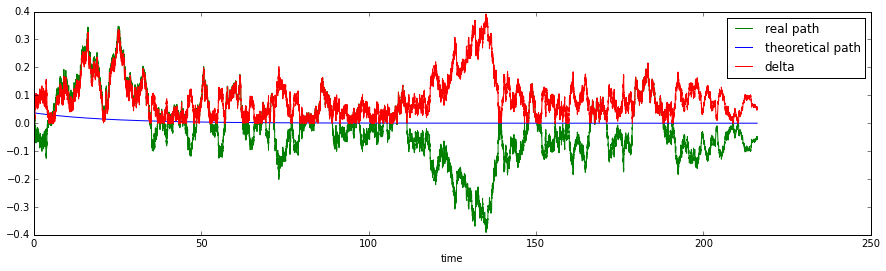

In [78]:
SIZE = 500
GTYPE = 'pois'
queue_size = 100000

def cdf(delta_utility):
    return snorm.cdf(delta_utility, loc=0.0, scale=5)
def get_vertex_degree():
    if GTYPE == 'pois':
        return pois.rvs(SIZE*0.01, 0, 1)[0]
    if GTYPE == 'randint':
        return np.random.randint(10)
    if GTYPE == 'zipf':
        return zipf_distr.rvs(2.5, loc=0, size=1, random_state=None)[0]
    
res_before = []
res_after = []

g, _ = gen_graph()
g_copy = cp(g)
for k in range(1):
    g = cp(g_copy)
    queue, times = get_queue(queue_size, SIZE)
    for i in range(len(queue)):
        revise_label(queue[i], times[i], g, SIZE, cdf)
    a_t = np.array(g.graph_properties["times"])

    real_path = np.array(g.graph_properties["m_w"])

    g = g_copy
    sol = integr.odeint(derivative_m_w, calc_start_m_w(), a_t)
    deltas = [abs(sol[i][0]-real_path[i]) for i in range(len(sol))]

    stable_i = 0
    smoothed = [1]*1000 + list([abs(np.mean(real_path[i:i+1000]) - np.mean(real_path[-1000:])) for i in range(len(real_path) - 1000)])
    for i in range(len(real_path)-1, 1000, -1):
        if smoothed[i] > 0.05:
            stable_i = i
            break
    res_before.append(np.mean(deltas[0: stable_i]))
    res_after.append(np.mean(deltas[stable_i:]))
    print "before stable = ", res_before[-1], "after stable = ", res_after[-1]      

    fig = plt.figure(figsize = (15, 4))
    ax = fig.add_subplot(111)
    ax.set_xlabel("time")

    ax.plot(a_t, real_path, color = "green", label="real path")
    ax.plot(a_t, sol, color = "blue", label="theoretical path")
    ax.plot(a_t, deltas, color = "red", label="delta")

    plt.legend(loc='best')

stable_before = []
stable_after = []
for i in range(len(res_before)):
    if res_after[i] < 1:
        stable_before.append(res_before[i])
        stable_after.append(res_after[i])
print "report: ", len(stable_before), np.mean(stable_before), np.mean(stable_after)

before stable =  0.68179488077 after stable =  1.15129956358
before stable =  0.386967233734 after stable =  0.89615017019
before stable =  0.510518165975 after stable =  1.11326871836
before stable =  0.492774038998 after stable =  1.17964185114
before stable =  0.320704974838 after stable =  0.834678742738
before stable =  0.160619358611 after stable =  0.256628464777
before stable =  0.371187493906 after stable =  1.12349853011
before stable =  0.124968323137 after stable =  0.19750471331
before stable =  0.254753577412 after stable =  0.637932888632
before stable =  0.155635922849 after stable =  0.411219543414
report:  6 0.233941565097 0.539019087177


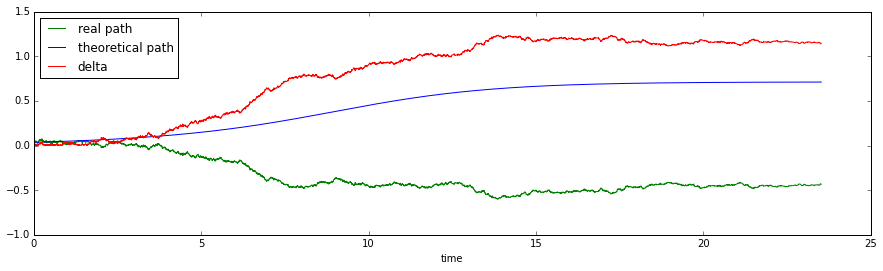

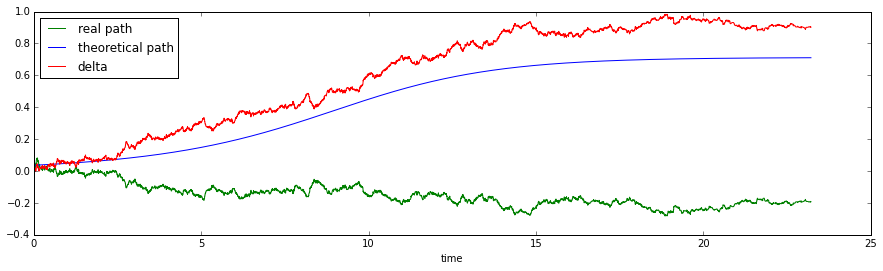

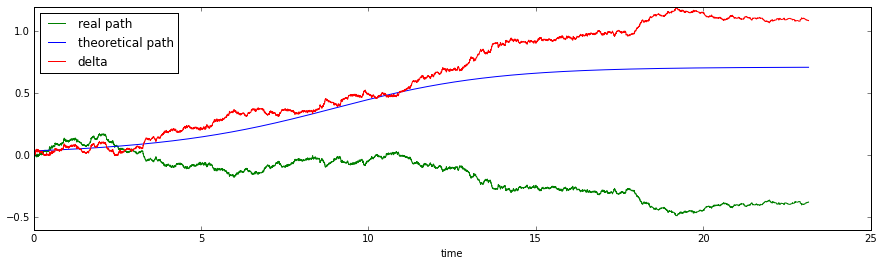

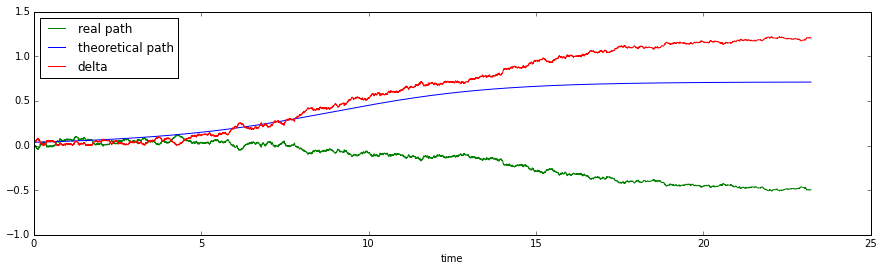

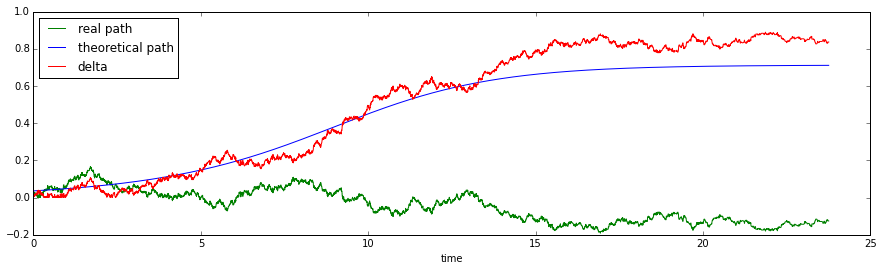

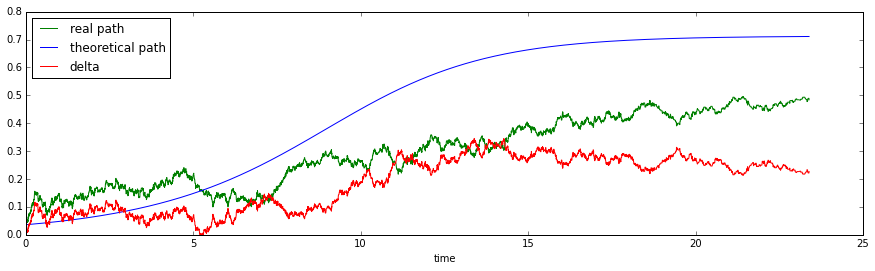

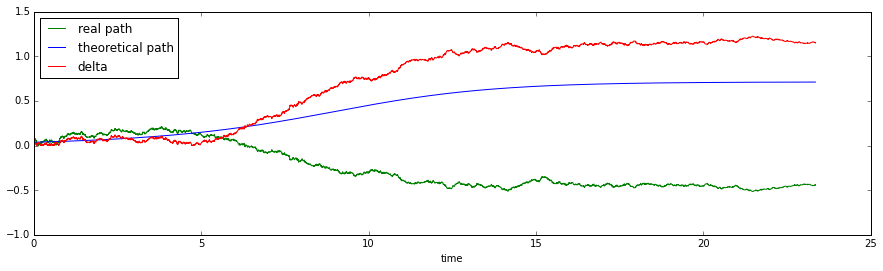

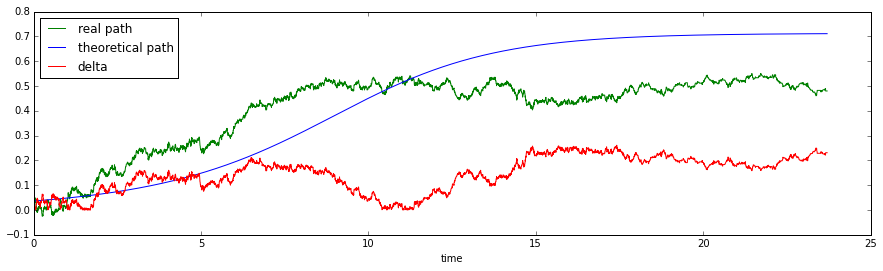

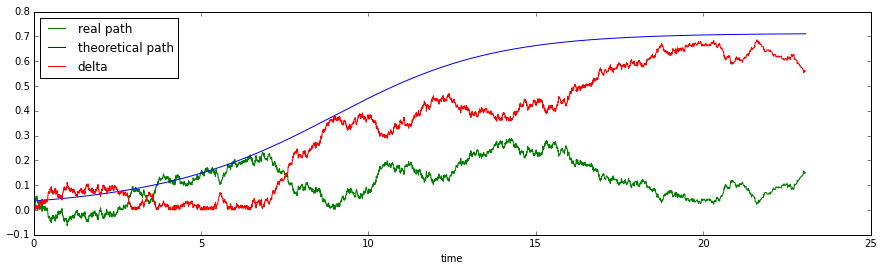

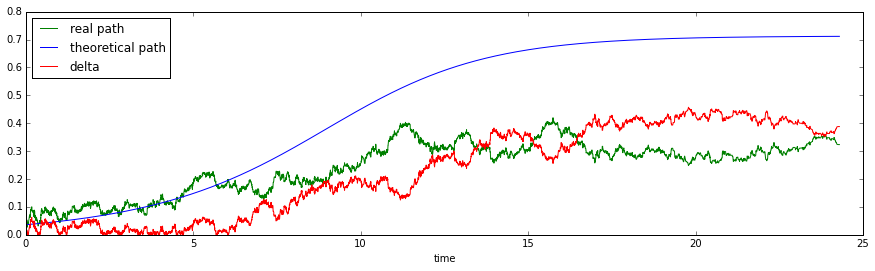

In [70]:
SIZE = 500
GTYPE = 'pois'
queue_size = 10000

def cdf(delta_utility):
    return snorm.cdf(delta_utility, loc=0.0, scale=5)
def get_vertex_degree():
    if GTYPE == 'pois':
        return pois.rvs(SIZE*0.014, 0, 1)[0]
    if GTYPE == 'randint':
        return np.random.randint(10)
    if GTYPE == 'zipf':
        return zipf_distr.rvs(2.5, loc=0, size=1, random_state=None)[0]
    
res_before = []
res_after = []

g, _ = gen_graph()
g_copy = cp(g)
for k in range(10):
    g = cp(g_copy)
    queue, times = get_queue(queue_size, SIZE)
    for i in range(len(queue)):
        revise_label(queue[i], times[i], g, SIZE, cdf)
    a_t = np.array(g.graph_properties["times"])

    real_path = np.array(g.graph_properties["m_w"])

    g = g_copy
    sol = integr.odeint(derivative_m_w, calc_start_m_w(), a_t)
    deltas = [abs(sol[i][0]-real_path[i]) for i in range(len(sol))]

    stable_i = 0
    smoothed = [1]*1000 + list([abs(np.mean(real_path[i:i+1000]) - np.mean(real_path[-1000:])) for i in range(len(real_path) - 1000)])
    for i in range(len(real_path)-1, 1000, -1):
        if smoothed[i] > 0.05:
            stable_i = i
            break
    res_before.append(np.mean(deltas[0: stable_i]))
    res_after.append(np.mean(deltas[stable_i:]))
    print "before stable = ", res_before[-1], "after stable = ", res_after[-1]      

    fig = plt.figure(figsize = (15, 4))
    ax = fig.add_subplot(111)
    ax.set_xlabel("time")

    ax.plot(a_t, real_path, color = "green", label="real path")
    ax.plot(a_t, sol, color = "blue", label="theoretical path")
    ax.plot(a_t, deltas, color = "red", label="delta")

    plt.legend(loc='best')

stable_before = []
stable_after = []
for i in range(len(res_before)):
    if res_after[i] < 1:
        stable_before.append(res_before[i])
        stable_after.append(res_after[i])
print "report: ", len(stable_before), np.mean(stable_before), np.mean(stable_after)

before stable =  0.294326398258 after stable =  0.000922829123868
before stable =  1.30349068199 after stable =  1.99841639415
before stable =  1.06431724639 after stable =  1.64500900673
before stable =  0.217726123264 after stable =  0.00180811740606
before stable =  1.26982117171 after stable =  1.99769134805
before stable =  0.432105000596 after stable =  0.00134616014881
before stable =  0.309688058097 after stable =  0.00117847684561
before stable =  1.27816179257 after stable =  1.99692668777
before stable =  0.325636741665 after stable =  0.00125735594063
before stable =  0.265844961622 after stable =  0.00116563819054
report:  6 0.30755454725 0.00127976294259


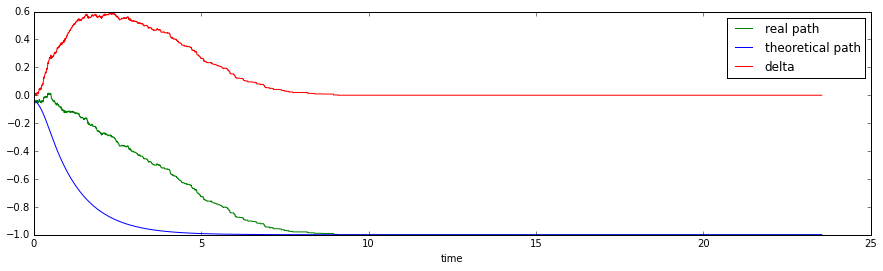

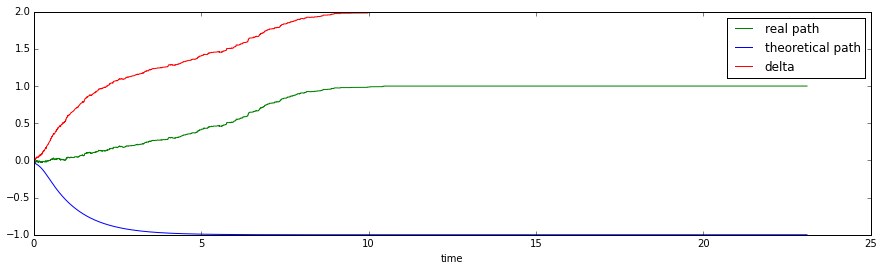

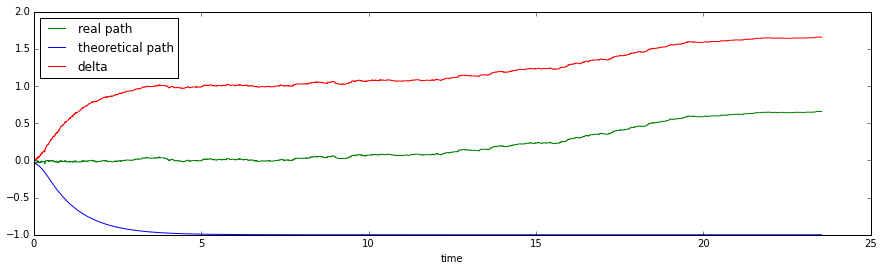

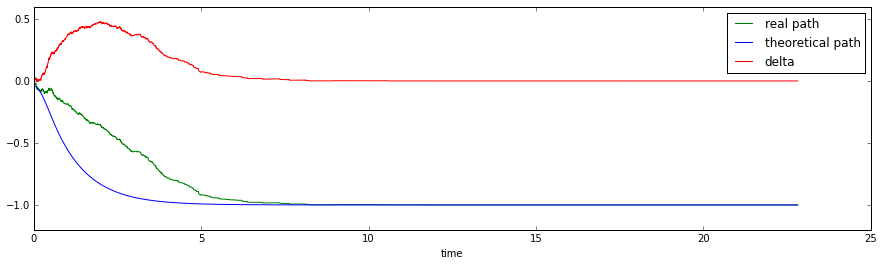

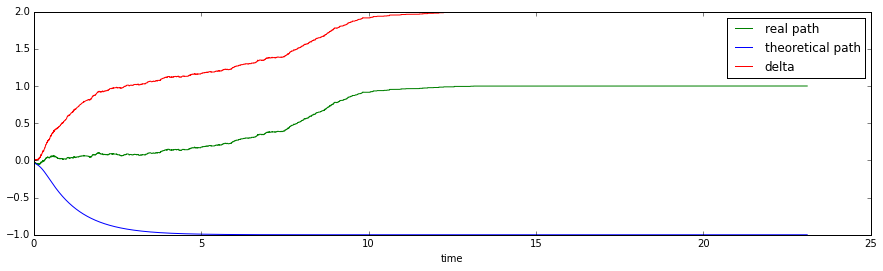

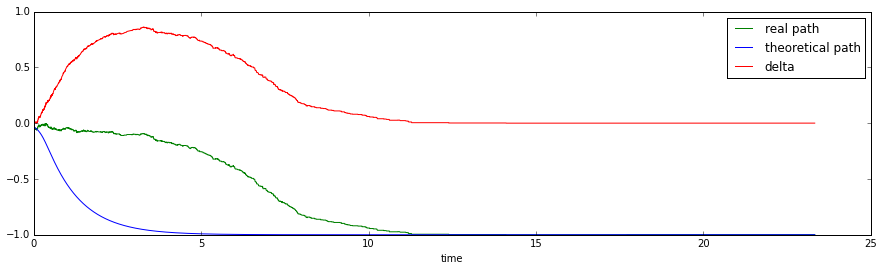

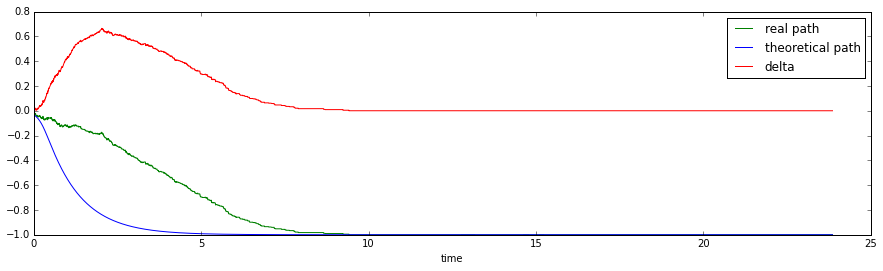

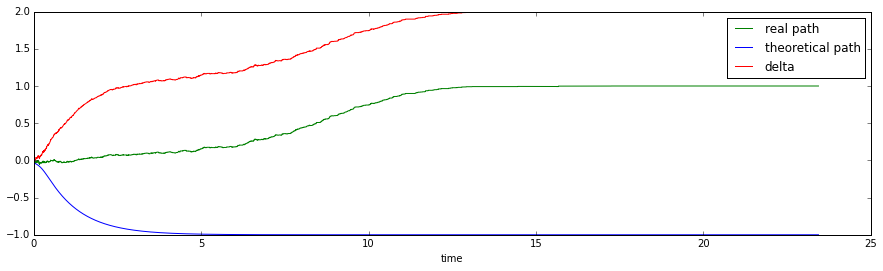

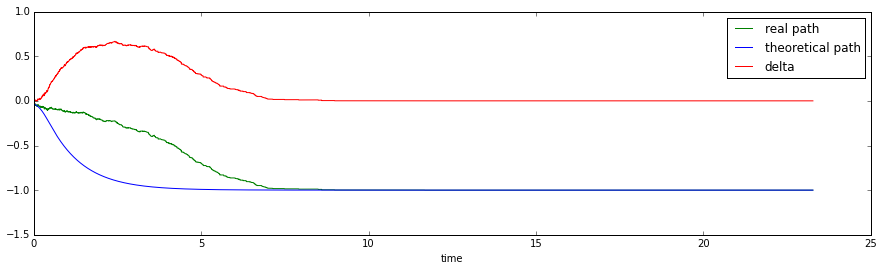

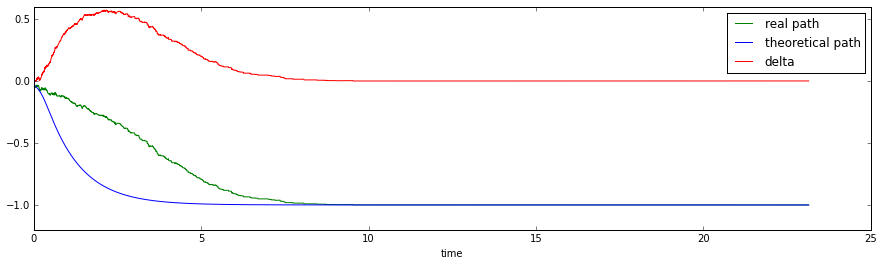

In [71]:
SIZE = 500
GTYPE = 'pois'
queue_size = 10000

def cdf(delta_utility):
    return snorm.cdf(delta_utility, loc=0.0, scale=1)
def get_vertex_degree():
    if GTYPE == 'pois':
        return pois.rvs(SIZE*0.014, 0, 1)[0]
    if GTYPE == 'randint':
        return np.random.randint(10)
    if GTYPE == 'zipf':
        return zipf_distr.rvs(2.5, loc=0, size=1, random_state=None)[0]
    
res_before = []
res_after = []

g, _ = gen_graph()
g_copy = cp(g)
for k in range(10):
    g = cp(g_copy)
    queue, times = get_queue(queue_size, SIZE)
    for i in range(len(queue)):
        revise_label(queue[i], times[i], g, SIZE, cdf)
    a_t = np.array(g.graph_properties["times"])

    real_path = np.array(g.graph_properties["m_w"])

    g = g_copy
    sol = integr.odeint(derivative_m_w, calc_start_m_w(), a_t)
    deltas = [abs(sol[i][0]-real_path[i]) for i in range(len(sol))]

    stable_i = 0
    smoothed = [1]*1000 + list([abs(np.mean(real_path[i:i+1000]) - np.mean(real_path[-1000:])) for i in range(len(real_path) - 1000)])
    for i in range(len(real_path)-1, 1000, -1):
        if smoothed[i] > 0.05:
            stable_i = i
            break
    res_before.append(np.mean(deltas[0: stable_i]))
    res_after.append(np.mean(deltas[stable_i:]))
    print "before stable = ", res_before[-1], "after stable = ", res_after[-1]      

    fig = plt.figure(figsize = (15, 4))
    ax = fig.add_subplot(111)
    ax.set_xlabel("time")

    ax.plot(a_t, real_path, color = "green", label="real path")
    ax.plot(a_t, sol, color = "blue", label="theoretical path")
    ax.plot(a_t, deltas, color = "red", label="delta")

    plt.legend(loc='best')

stable_before = []
stable_after = []
for i in range(len(res_before)):
    if res_after[i] < 1:
        stable_before.append(res_before[i])
        stable_after.append(res_after[i])
print "report: ", len(stable_before), np.mean(stable_before), np.mean(stable_after)

before stable =  0.0320090160512 after stable =  0.00495041844593
before stable =  0.0515242590143 after stable =  0.00893411025566
before stable =  1.10399655513 after stable =  1.95918434315
before stable =  1.19156187479 after stable =  1.96596232508
before stable =  0.0795659302195 after stable =  0.00688844022004
before stable =  0.0130493425663 after stable =  0.00804876218447
before stable =  0.0935367905341 after stable =  0.00589928275073
before stable =  0.0121408883853 after stable =  0.00835005375601
before stable =  1.09777700387 after stable =  1.96064832304
before stable =  0.0444959017981 after stable =  0.00599739096592
report:  7 0.0466174469384 0.00700977979697


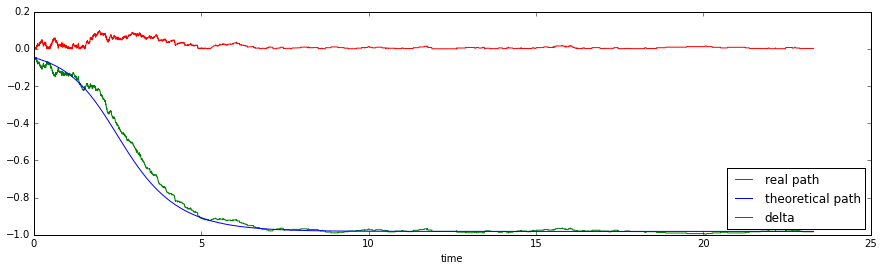

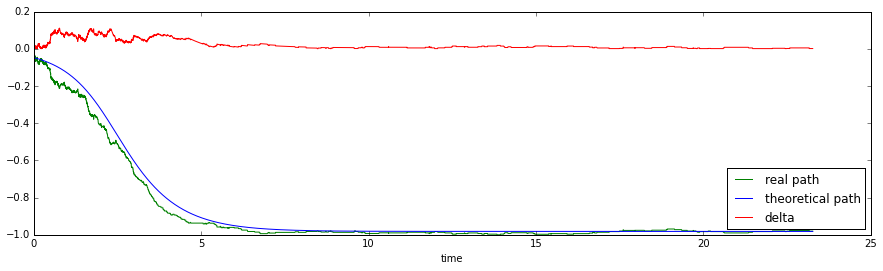

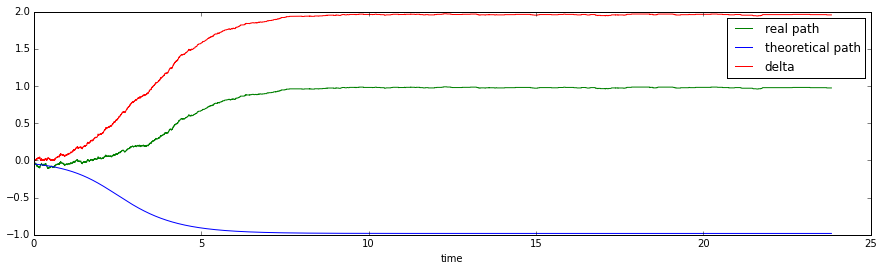

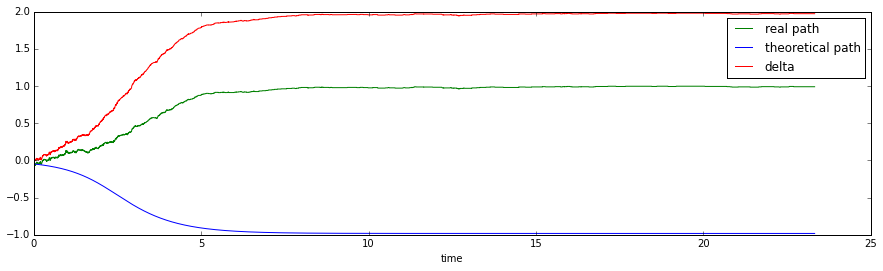

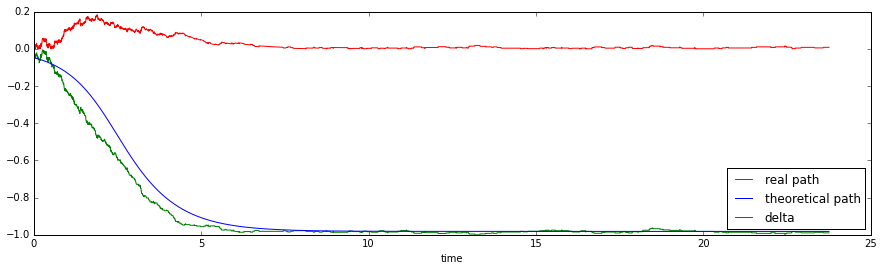

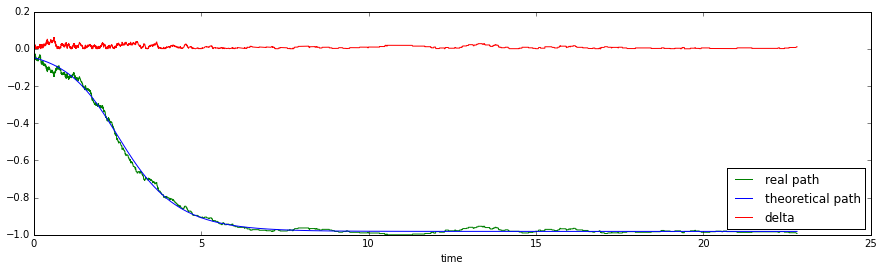

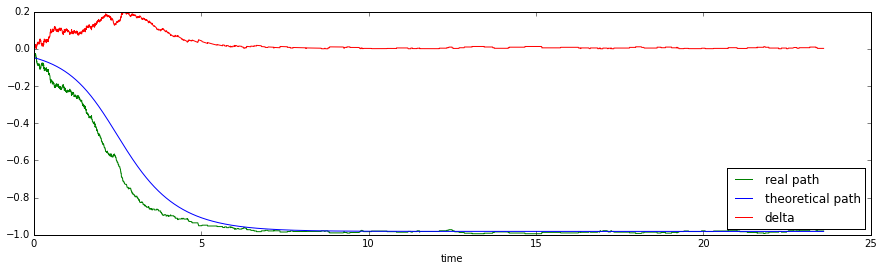

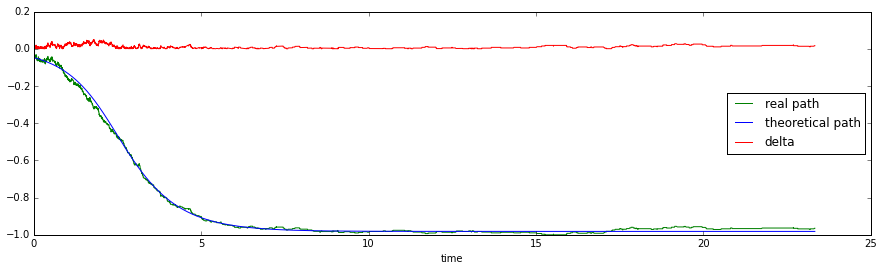

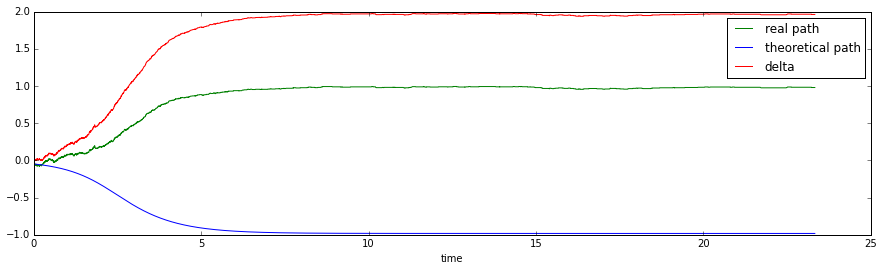

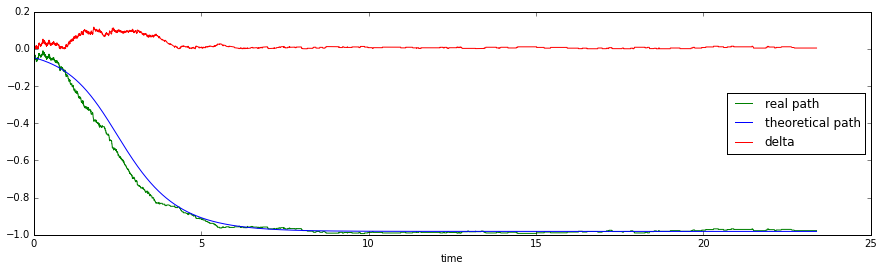

In [77]:
SIZE = 500
GTYPE = 'pois'
queue_size = 10000

def cdf(delta_utility):
    return snorm.cdf(delta_utility, loc=0.0, scale=20)
def get_vertex_degree():
    if GTYPE == 'pois':
        return pois.rvs(SIZE*0.1, 0, 1)[0]
    if GTYPE == 'randint':
        return np.random.randint(10)
    if GTYPE == 'zipf':
        return zipf_distr.rvs(2.5, loc=0, size=1, random_state=None)[0]
    
res_before = []
res_after = []

g, _ = gen_graph()
g_copy = cp(g)
for k in range(10):
    g = cp(g_copy)
    queue, times = get_queue(queue_size, SIZE)
    for i in range(len(queue)):
        revise_label(queue[i], times[i], g, SIZE, cdf)
    a_t = np.array(g.graph_properties["times"])

    real_path = np.array(g.graph_properties["m_w"])

    g = g_copy
    sol = integr.odeint(derivative_m_w, calc_start_m_w(), a_t)
    deltas = [abs(sol[i][0]-real_path[i]) for i in range(len(sol))]

    stable_i = 0
    smoothed = [1]*1000 + list([abs(np.mean(real_path[i:i+1000]) - np.mean(real_path[-1000:])) for i in range(len(real_path) - 1000)])
    for i in range(len(real_path)-1, 1000, -1):
        if smoothed[i] > 0.05:
            stable_i = i
            break
    res_before.append(np.mean(deltas[0: stable_i]))
    res_after.append(np.mean(deltas[stable_i:]))
    print "before stable = ", res_before[-1], "after stable = ", res_after[-1]      

    fig = plt.figure(figsize = (15, 4))
    ax = fig.add_subplot(111)
    ax.set_xlabel("time")

    ax.plot(a_t, real_path, color = "green", label="real path")
    ax.plot(a_t, sol, color = "blue", label="theoretical path")
    ax.plot(a_t, deltas, color = "red", label="delta")

    plt.legend(loc='best')

stable_before = []
stable_after = []
for i in range(len(res_before)):
    if res_after[i] < 1:
        stable_before.append(res_before[i])
        stable_after.append(res_after[i])
print "report: ", len(stable_before), np.mean(stable_before), np.mean(stable_after)

before stable =  0.0870843168201 after stable =  0.109994080179
before stable =  0.406125002948 after stable =  0.352384269482
before stable =  0.100917877265 after stable =  0.0308251670437
before stable =  0.0960225675719 after stable =  0.036952573777
before stable =  0.058039856447 after stable =  0.107296403397
before stable =  0.19996824494 after stable =  0.271394921284
before stable =  0.26271925055 after stable =  0.253724784386
before stable =  0.46078178129 after stable =  0.679814821424
before stable =  0.103087232181 after stable =  0.0321974213328
before stable =  0.268386179764 after stable =  0.518191827206
report:  10 0.204313230978 0.239277626951


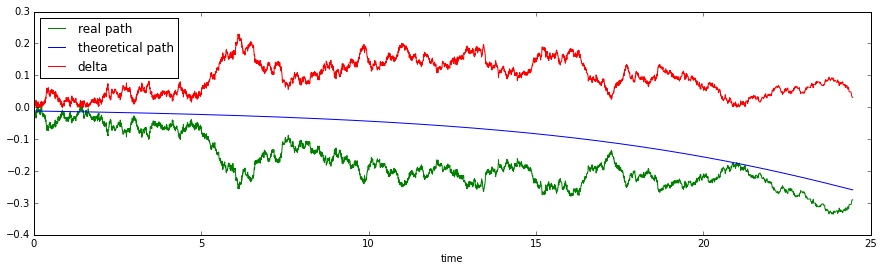

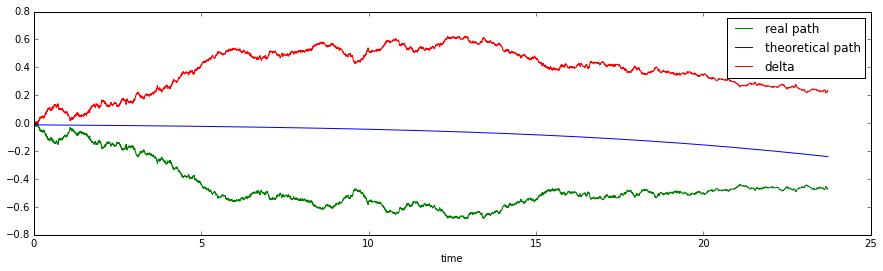

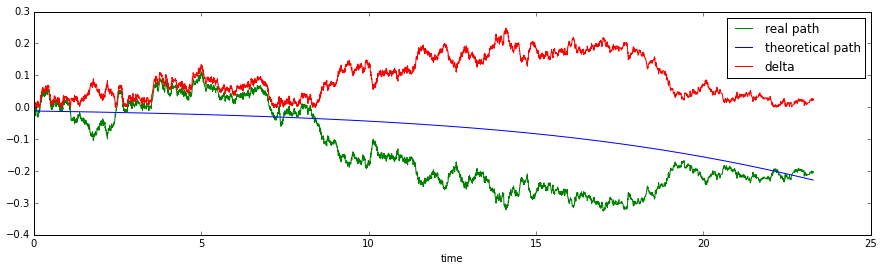

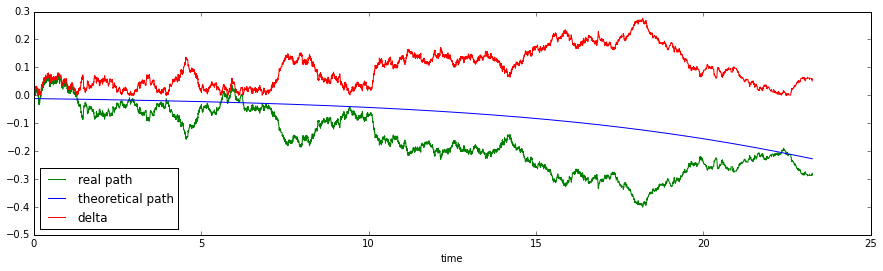

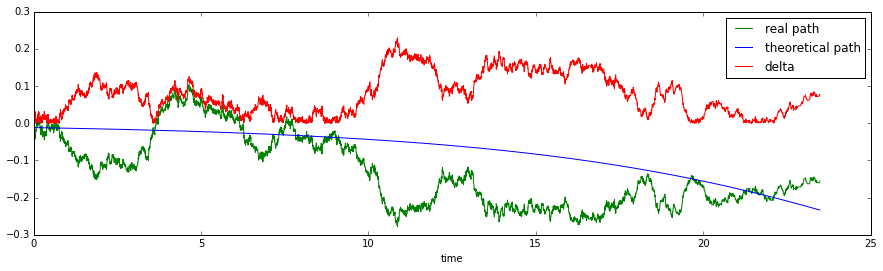

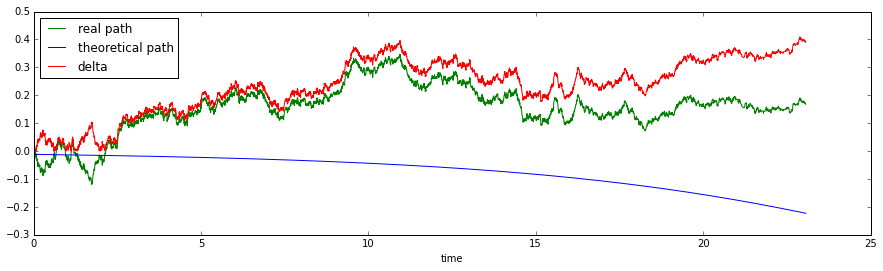

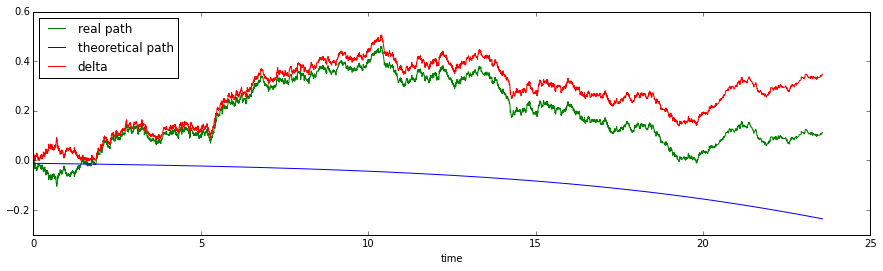

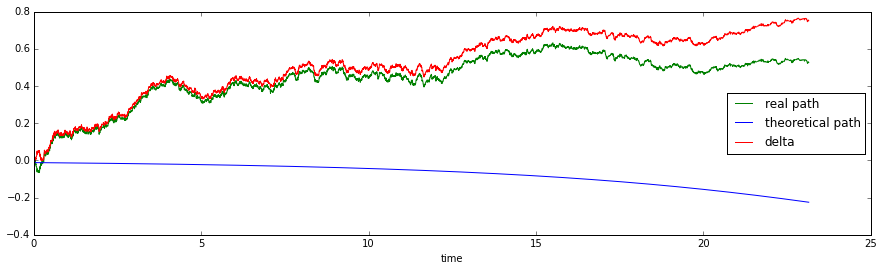

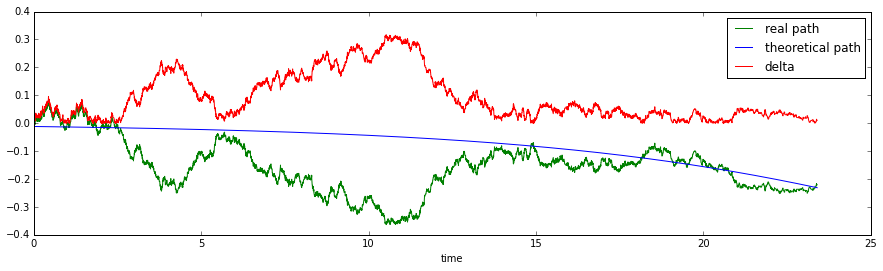

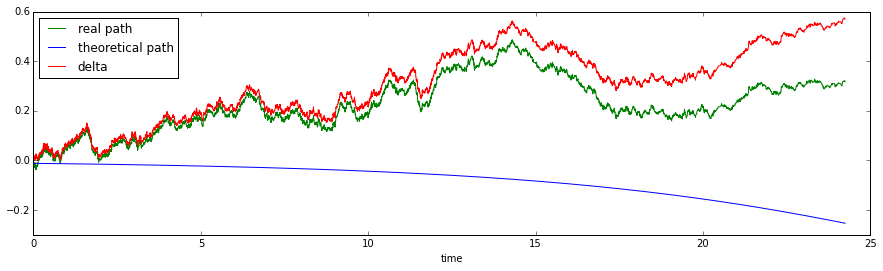

In [73]:
SIZE = 500
GTYPE = 'pois'
queue_size = 10000

def cdf(delta_utility):
    return snorm.cdf(delta_utility, loc=0.0, scale=36)
def get_vertex_degree():
    if GTYPE == 'pois':
        return pois.rvs(SIZE*0.1, 0, 1)[0]
    if GTYPE == 'randint':
        return np.random.randint(10)
    if GTYPE == 'zipf':
        return zipf_distr.rvs(2.5, loc=0, size=1, random_state=None)[0]
    
res_before = []
res_after = []

g, _ = gen_graph()
g_copy = cp(g)
for k in range(10):
    g = cp(g_copy)
    queue, times = get_queue(queue_size, SIZE)
    for i in range(len(queue)):
        revise_label(queue[i], times[i], g, SIZE, cdf)
    a_t = np.array(g.graph_properties["times"])

    real_path = np.array(g.graph_properties["m_w"])

    g = g_copy
    sol = integr.odeint(derivative_m_w, calc_start_m_w(), a_t)
    deltas = [abs(sol[i][0]-real_path[i]) for i in range(len(sol))]

    stable_i = 0
    smoothed = [1]*1000 + list([abs(np.mean(real_path[i:i+1000]) - np.mean(real_path[-1000:])) for i in range(len(real_path) - 1000)])
    for i in range(len(real_path)-1, 1000, -1):
        if smoothed[i] > 0.05:
            stable_i = i
            break
    res_before.append(np.mean(deltas[0: stable_i]))
    res_after.append(np.mean(deltas[stable_i:]))
    print "before stable = ", res_before[-1], "after stable = ", res_after[-1]      

    fig = plt.figure(figsize = (15, 4))
    ax = fig.add_subplot(111)
    ax.set_xlabel("time")

    ax.plot(a_t, real_path, color = "green", label="real path")
    ax.plot(a_t, sol, color = "blue", label="theoretical path")
    ax.plot(a_t, deltas, color = "red", label="delta")

    plt.legend(loc='best')

stable_before = []
stable_after = []
for i in range(len(res_before)):
    if res_after[i] < 1:
        stable_before.append(res_before[i])
        stable_after.append(res_after[i])
print "report: ", len(stable_before), np.mean(stable_before), np.mean(stable_after)

before stable =  1.07313838555 after stable =  1.99138031893
before stable =  0.0612006669049 after stable =  0.00333230904302
before stable =  0.0347460330951 after stable =  0.00318745934414
before stable =  0.0331486091022 after stable =  0.00418285392083
before stable =  0.0316586022046 after stable =  0.00360804461038
before stable =  0.126612816531 after stable =  0.00463146125288
before stable =  0.0746731472469 after stable =  0.00436883495683
before stable =  1.10200843514 after stable =  1.9907255035
before stable =  0.146631499174 after stable =  0.00443084355945
before stable =  1.09124058489 after stable =  1.99081164334
report:  7 0.0726673391797 0.00396311524107


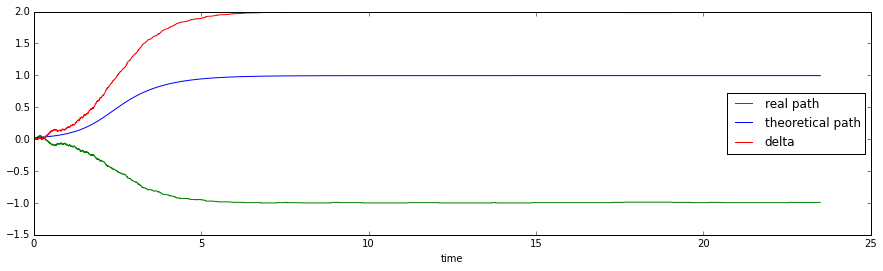

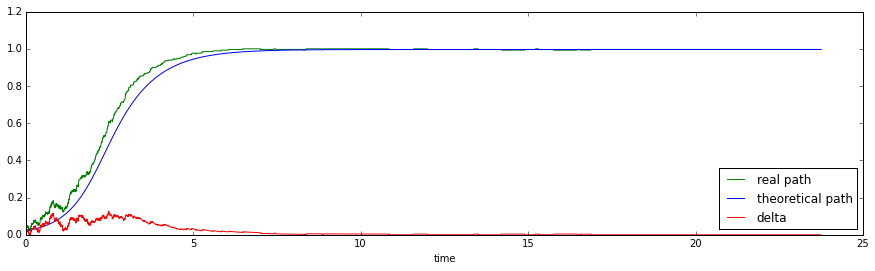

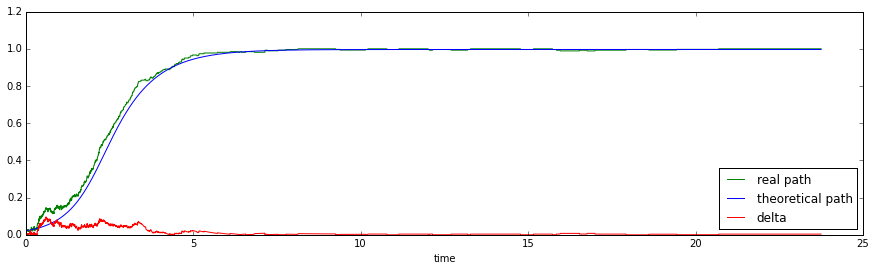

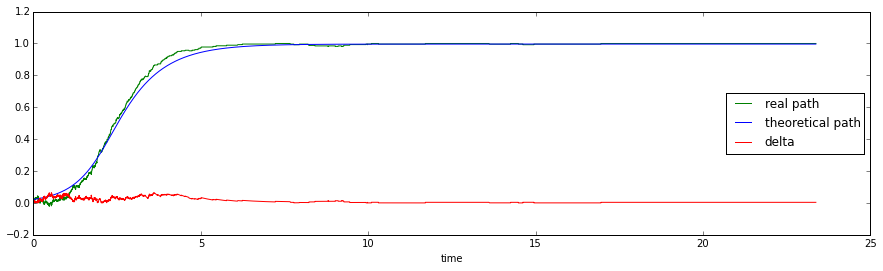

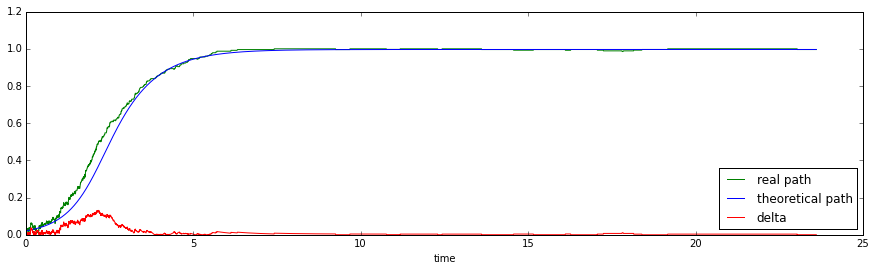

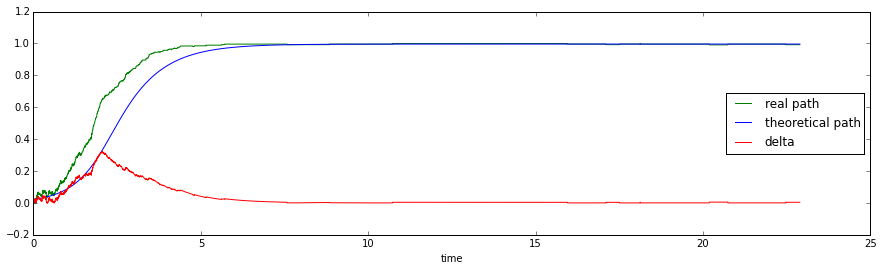

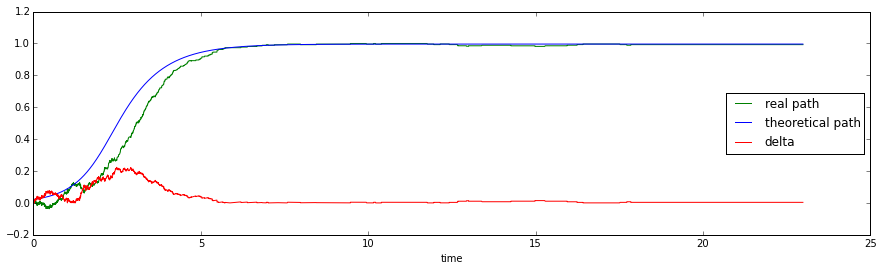

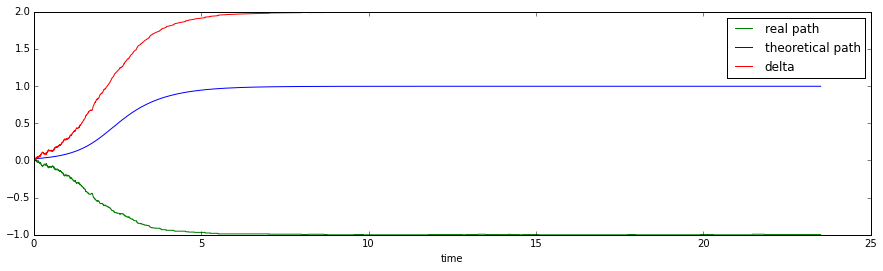

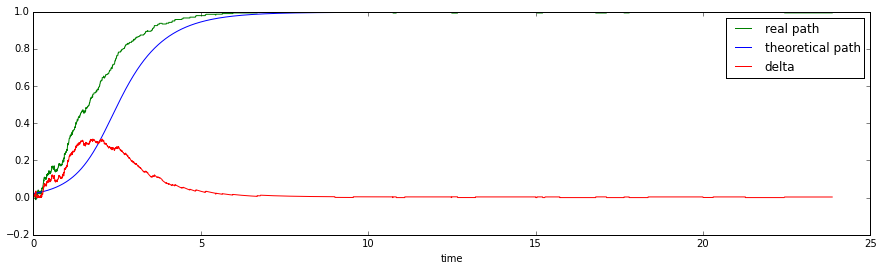

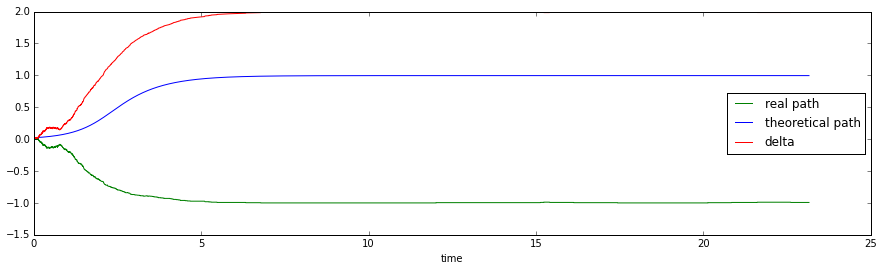

In [75]:
SIZE = 500
GTYPE = 'pois'
queue_size = 10000

def cdf(delta_utility):
    return snorm.cdf(delta_utility, loc=0.0, scale=50)
def get_vertex_degree():
    if GTYPE == 'pois':
        return pois.rvs(SIZE*0.3, 0, 1)[0]
    if GTYPE == 'randint':
        return np.random.randint(10)
    if GTYPE == 'zipf':
        return zipf_distr.rvs(2.5, loc=0, size=1, random_state=None)[0]
    
res_before = []
res_after = []

g, _ = gen_graph()
g_copy = cp(g)
for k in range(10):
    g = cp(g_copy)
    queue, times = get_queue(queue_size, SIZE)
    for i in range(len(queue)):
        revise_label(queue[i], times[i], g, SIZE, cdf)
    a_t = np.array(g.graph_properties["times"])

    real_path = np.array(g.graph_properties["m_w"])

    g = g_copy
    sol = integr.odeint(derivative_m_w, calc_start_m_w(), a_t)
    deltas = [abs(sol[i][0]-real_path[i]) for i in range(len(sol))]

    stable_i = 0
    smoothed = [1]*1000 + list([abs(np.mean(real_path[i:i+1000]) - np.mean(real_path[-1000:])) for i in range(len(real_path) - 1000)])
    for i in range(len(real_path)-1, 1000, -1):
        if smoothed[i] > 0.05:
            stable_i = i
            break
    res_before.append(np.mean(deltas[0: stable_i]))
    res_after.append(np.mean(deltas[stable_i:]))
    print "before stable = ", res_before[-1], "after stable = ", res_after[-1]      

    fig = plt.figure(figsize = (15, 4))
    ax = fig.add_subplot(111)
    ax.set_xlabel("time")

    ax.plot(a_t, real_path, color = "green", label="real path")
    ax.plot(a_t, sol, color = "blue", label="theoretical path")
    ax.plot(a_t, deltas, color = "red", label="delta")

    plt.legend(loc='best')

stable_before = []
stable_after = []
for i in range(len(res_before)):
    if res_after[i] < 1:
        stable_before.append(res_before[i])
        stable_after.append(res_after[i])
print "report: ", len(stable_before), np.mean(stable_before), np.mean(stable_after)

before stable =  0.06242062342 after stable =  0.0754168074881
before stable =  0.0547554355657 after stable =  0.0217836815513
before stable =  0.0633382329079 after stable =  0.0486001012906
before stable =  0.0575399761967 after stable =  0.0172008540619
report:  4 0.0595135670226 0.040750361098


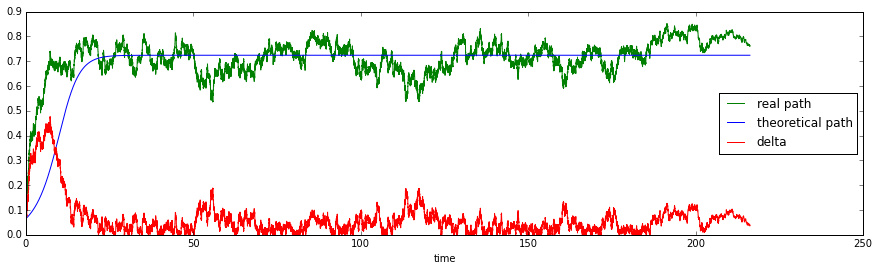

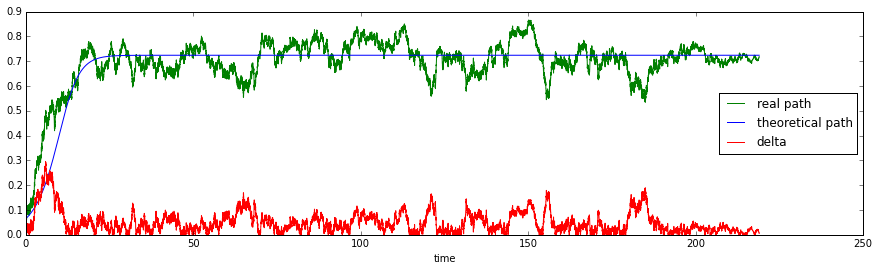

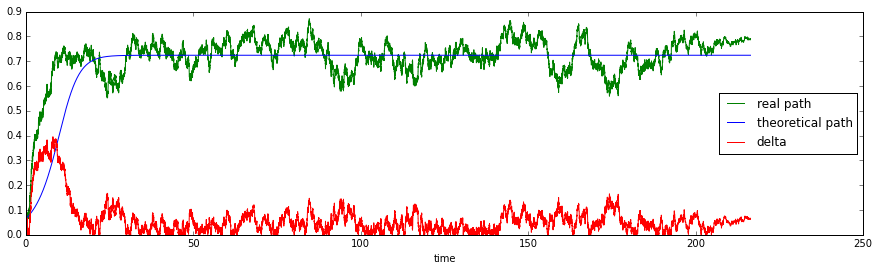

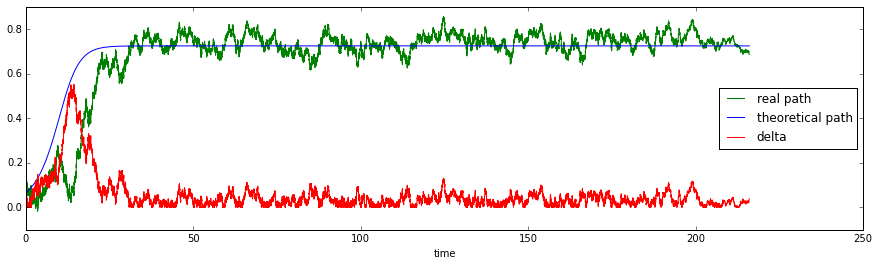

In [79]:
SIZE = 500
GTYPE = 'pois'
queue_size = 100000

def cdf(delta_utility):
    return snorm.cdf(delta_utility, loc=0.0, scale=100)
def get_vertex_degree():
    if GTYPE == 'pois':
        return pois.rvs(SIZE*0.3, 0, 1)[0]
    if GTYPE == 'randint':
        return np.random.randint(10)
    if GTYPE == 'zipf':
        return zipf_distr.rvs(2.5, loc=0, size=1, random_state=None)[0]
    
res_before = []
res_after = []

g, _ = gen_graph()
g_copy = cp(g)
for k in range(4):
    g = cp(g_copy)
    queue, times = get_queue(queue_size, SIZE)
    for i in range(len(queue)):
        revise_label(queue[i], times[i], g, SIZE, cdf)
    a_t = np.array(g.graph_properties["times"])

    real_path = np.array(g.graph_properties["m_w"])

    g = g_copy
    sol = integr.odeint(derivative_m_w, calc_start_m_w(), a_t)
    deltas = [abs(sol[i][0]-real_path[i]) for i in range(len(sol))]

    stable_i = 0
    smoothed = [1]*1000 + list([abs(np.mean(real_path[i:i+1000]) - np.mean(real_path[-1000:])) for i in range(len(real_path) - 1000)])
    for i in range(len(real_path)-1, 1000, -1):
        if smoothed[i] > 0.05:
            stable_i = i
            break
    res_before.append(np.mean(deltas[0: stable_i]))
    res_after.append(np.mean(deltas[stable_i:]))
    print "before stable = ", res_before[-1], "after stable = ", res_after[-1]      

    fig = plt.figure(figsize = (15, 4))
    ax = fig.add_subplot(111)
    ax.set_xlabel("time")

    ax.plot(a_t, real_path, color = "green", label="real path")
    ax.plot(a_t, sol, color = "blue", label="theoretical path")
    ax.plot(a_t, deltas, color = "red", label="delta")

    plt.legend(loc='best')

stable_before = []
stable_after = []
for i in range(len(res_before)):
    if res_after[i] < 1:
        stable_before.append(res_before[i])
        stable_after.append(res_after[i])
print "report: ", len(stable_before), np.mean(stable_before), np.mean(stable_after)

In [81]:
SIZE = 500
GTYPE = 'pois'
queue_size = 30000

def cdf(delta_utility):
    return snorm.cdf(delta_utility, loc=0.0, scale=100)
def get_vertex_degree():
    if GTYPE == 'pois':
        return pois.rvs(SIZE*0.3, 0, 1)[0]
    if GTYPE == 'randint':
        return np.random.randint(10)
    if GTYPE == 'zipf':
        return zipf_distr.rvs(2.5, loc=0, size=1, random_state=None)[0]
    
res_before = []
res_after = []

g, _ = gen_graph()
g_copy = cp(g)
for k in range(10):
    g = cp(g_copy)
    queue, times = get_queue(queue_size, SIZE)
    for i in range(len(queue)):
        revise_label(queue[i], times[i], g, SIZE, cdf)
    a_t = np.array(g.graph_properties["times"])

    real_path = np.array(g.graph_properties["m_w"])

    g = g_copy
    sol = integr.odeint(derivative_m_w, calc_start_m_w(), a_t)
    deltas = [abs(sol[i][0]-real_path[i]) for i in range(len(sol))]

    stable_i = 0
    smoothed = [1]*1000 + list([abs(np.mean(real_path[i:i+1000]) - np.mean(real_path[-1000:])) for i in range(len(real_path) - 1000)])
    for i in range(len(real_path)-1, 1000, -1):
        if smoothed[i] > 0.05:
            stable_i = i
            break
    res_before.append(np.mean(deltas[0: stable_i]))
    res_after.append(np.mean(deltas[stable_i:]))
    print "before stable = ", res_before[-1], "after stable = ", res_after[-1]      

#    fig = plt.figure(figsize = (15, 4))
#    ax = fig.add_subplot(111)
#    ax.set_xlabel("time")

#    ax.plot(a_t, real_path, color = "green", label="real path")
#    ax.plot(a_t, sol, color = "blue", label="theoretical path")
#    ax.plot(a_t, deltas, color = "red", label="delta")

#    plt.legend(loc='best')

stable_before = []
stable_after = []
for i in range(len(res_before)):
    if res_after[i] < 1:
        stable_before.append(res_before[i])
        stable_after.append(res_after[i])
print "report: ", len(stable_before), np.mean(stable_before), np.mean(stable_after)

before stable =  0.14159480672 after stable =  0.0303106790141
before stable =  1.13123865176 after stable =  1.50419087095
before stable =  1.11065530855 after stable =  1.37158912999
before stable =  0.171211061774 after stable =  0.0636188177212
before stable =  0.179884878355 after stable =  0.0322392052416
before stable =  0.0965238302684 after stable =  0.0642374403692
before stable =  1.12843694057 after stable =  1.3151762341
before stable =  0.141097193374 after stable =  0.0199575926663
before stable =  0.0659420118282 after stable =  0.0470506319335
before stable =  0.20572918673 after stable =  0.0341122966986
report:  7 0.14314042415 0.0416466662349


# Долговременные тесты

In [89]:
def gen_graph():
    g = gt.random_graph(SIZE, get_vertex_degree, directed=False)
    labels = g.new_vertex_property("int")
    weighted_total = g.new_graph_property("vector<double>")
    revise_times = g.new_graph_property("vector<double>")
    k_mean = g.new_graph_property("double")
    
    g.vertex_properties["labels"] = labels
    g.graph_properties["m_w"] = weighted_total
    g.graph_properties["times"] = revise_times
    g.graph_properties["k_mean"] = k_mean
    
#    labels_mean = g.new_vertex_property("vector<int>")  
    vertices = [item for item in g.vertices()]
    
    # начальное распределение на вершины
    for vertex in vertices:
        labels[vertex] = np.random.binomial(1, 0.5, 1) * 2 - 1
#        labels_mean[vertex].append(0)
    # среднее значение степени вершины
    k_mean[g] = np.mean([g.degree_property_map('out')[v] for v in g.vertices()])
    revise_times[g].append(0)
    weight = 1.0 * np.sum([labels[v]*g.degree_property_map('out')[v] for v in g.vertices()])
    weight /= SIZE
    weight /= k_mean[g]
    weighted_total[g].append(weight)
    
    pos = graph_tool.draw.sfdp_layout(g)
    
    return g, pos

In [90]:
SIZE = 500
GTYPE = 'pois'
queue_size = 10000

def cdf(delta_utility):
    return snorm.cdf(delta_utility, loc=0.0, scale=5)
def get_vertex_degree():
    if GTYPE == 'pois':
        return pois.rvs(SIZE*0.01, 0, 1)[0]
    if GTYPE == 'randint':
        return np.random.randint(10)
    if GTYPE == 'zipf':
        return zipf_distr.rvs(2.5, loc=0, size=1, random_state=None)[0]

final_res_before = []
final_res_after = []

for temp in range(10):
    g, _ = gen_graph()
    g_copy = cp(g)
    res_before = []
    res_after = []
    for k in range(10):
        g = cp(g_copy)
        queue, times = get_queue(queue_size, SIZE)
        for i in range(len(queue)):
            revise_label(queue[i], times[i], g, SIZE, cdf)
        a_t = np.array(g.graph_properties["times"])

        real_path = np.array(g.graph_properties["m_w"])

        g = g_copy
        sol = integr.odeint(derivative_m_w, calc_start_m_w(), a_t)
        deltas = [abs(sol[i][0]-real_path[i]) for i in range(len(sol))]

        stable_i = 0
        smoothed = [1]*1000 + list([abs(np.mean(real_path[i:i+1000]) - np.mean(real_path[-1000:])) for i in range(len(real_path) - 1000)])
        for i in range(len(real_path)-1, 1000, -1):
            if smoothed[i] > 0.05:
                stable_i = i
                break
        res_before.append(np.mean(deltas[0: stable_i]))
        res_after.append(np.mean(deltas[stable_i:]))
        print "before stable = ", res_before[-1], "after stable = ", res_after[-1]      

    stable_before = []
    stable_after = []
    for i in range(len(res_before)):
        if res_after[i] < 1:
            stable_before.append(res_before[i])
            stable_after.append(res_after[i])
    if (len(stable_before) > 0) :
        final_res_before.append(np.mean(stable_before))
        final_res_after.append(np.mean(stable_after))
    print "report: ", len(stable_before), np.mean(stable_before), np.mean(stable_after)
if (len(final_res_after) > 0):
    print "final report: mean error before=", np.mean(final_res_before), "std =", np.std(final_res_before) 
    print "final report: mean error after =", np.mean(final_res_after), "std =", np.std(final_res_after)

before stable =  0.0624843853637 after stable =  0.0194060340195
before stable =  0.0799837234692 after stable =  0.147525902227
before stable =  0.0687887641034 after stable =  0.0485116793998
before stable =  0.110813717896 after stable =  0.138244229168
before stable =  0.0644290051415 after stable =  0.112482246132
before stable =  0.0610841938903 after stable =  0.0790018973628
before stable =  0.101873682992 after stable =  0.0787725425455
before stable =  0.0402680811583 after stable =  0.0647676380291
before stable =  0.0912956629613 after stable =  0.0365060673908
before stable =  0.0888000820828 after stable =  0.0569418844416
report:  10 0.0769821299058 0.0782160120716
before stable =  0.0709601076167 after stable =  0.100652515018
before stable =  0.138120481624 after stable =  0.0568561931671
before stable =  0.0690242605484 after stable =  0.0744583730512
before stable =  0.0662140198274 after stable =  0.0793168988533
before stable =  0.0556365979979 after stable =  0.07

In [91]:
SIZE = 500
GTYPE = 'pois'
queue_size = 10000

def cdf(delta_utility):
    return snorm.cdf(delta_utility, loc=0.0, scale=5)
def get_vertex_degree():
    if GTYPE == 'pois':
        return pois.rvs(SIZE*0.014, 0, 1)[0]
    if GTYPE == 'randint':
        return np.random.randint(10)
    if GTYPE == 'zipf':
        return zipf_distr.rvs(2.5, loc=0, size=1, random_state=None)[0]

final_res_before = []
final_res_after = []

for temp in range(10):
    g, _ = gen_graph()
    g_copy = cp(g)
    res_before = []
    res_after = []
    for k in range(10):
        g = cp(g_copy)
        queue, times = get_queue(queue_size, SIZE)
        for i in range(len(queue)):
            revise_label(queue[i], times[i], g, SIZE, cdf)
        a_t = np.array(g.graph_properties["times"])

        real_path = np.array(g.graph_properties["m_w"])

        g = g_copy
        sol = integr.odeint(derivative_m_w, calc_start_m_w(), a_t)
        deltas = [abs(sol[i][0]-real_path[i]) for i in range(len(sol))]

        stable_i = 0
        smoothed = [1]*1000 + list([abs(np.mean(real_path[i:i+1000]) - np.mean(real_path[-1000:])) for i in range(len(real_path) - 1000)])
        for i in range(len(real_path)-1, 1000, -1):
            if smoothed[i] > 0.05:
                stable_i = i
                break
        res_before.append(np.mean(deltas[0: stable_i]))
        res_after.append(np.mean(deltas[stable_i:]))
        print "before stable = ", res_before[-1], "after stable = ", res_after[-1]      

    stable_before = []
    stable_after = []
    for i in range(len(res_before)):
        if res_after[i] < 1:
            stable_before.append(res_before[i])
            stable_after.append(res_after[i])
    if (len(stable_before) > 0) :
        final_res_before.append(np.mean(stable_before))
        final_res_after.append(np.mean(stable_after))
    print "report: ", len(stable_before), np.mean(stable_before), np.mean(stable_after)
if (len(final_res_after) > 0):
    print "final report: mean error before=", np.mean(final_res_before), "std =", np.std(final_res_before) 
    print "final report: mean error after =", np.mean(final_res_after), "std =", np.std(final_res_after)

before stable =  0.129875506694 after stable =  0.0914693073987
before stable =  0.19095691011 after stable =  0.290173781648
before stable =  0.504439569315 after stable =  0.973225913701
before stable =  0.556742321356 after stable =  1.05463403219
before stable =  0.54839933755 after stable =  1.10452885808
before stable =  0.544502678605 after stable =  0.8051596381
before stable =  0.25450541402 after stable =  0.424406705757
before stable =  0.0855194036166 after stable =  0.121448745201
before stable =  0.125508170666 after stable =  0.178956236593
before stable =  0.523773870482 after stable =  1.14860082116
report:  7 0.262186807575 0.412120046914
before stable =  0.57043074895 after stable =  0.968259217116
before stable =  0.110274475474 after stable =  0.0994857825027
before stable =  0.0851446059538 after stable =  0.135827066489
before stable =  0.522107685872 after stable =  1.13719622032
before stable =  0.197574707698 after stable =  0.338865112815
before stable =  0.1

In [92]:
SIZE = 500
GTYPE = 'pois'
queue_size = 10000

def cdf(delta_utility):
    return snorm.cdf(delta_utility, loc=0.0, scale=1)
def get_vertex_degree():
    if GTYPE == 'pois':
        return pois.rvs(SIZE*0.014, 0, 1)[0]
    if GTYPE == 'randint':
        return np.random.randint(10)
    if GTYPE == 'zipf':
        return zipf_distr.rvs(2.5, loc=0, size=1, random_state=None)[0]

final_res_before = []
final_res_after = []

for temp in range(10):
    g, _ = gen_graph()
    g_copy = cp(g)
    res_before = []
    res_after = []
    for k in range(10):
        g = cp(g_copy)
        queue, times = get_queue(queue_size, SIZE)
        for i in range(len(queue)):
            revise_label(queue[i], times[i], g, SIZE, cdf)
        a_t = np.array(g.graph_properties["times"])

        real_path = np.array(g.graph_properties["m_w"])

        g = g_copy
        sol = integr.odeint(derivative_m_w, calc_start_m_w(), a_t)
        deltas = [abs(sol[i][0]-real_path[i]) for i in range(len(sol))]

        stable_i = 0
        smoothed = [1]*1000 + list([abs(np.mean(real_path[i:i+1000]) - np.mean(real_path[-1000:])) for i in range(len(real_path) - 1000)])
        for i in range(len(real_path)-1, 1000, -1):
            if smoothed[i] > 0.05:
                stable_i = i
                break
        res_before.append(np.mean(deltas[0: stable_i]))
        res_after.append(np.mean(deltas[stable_i:]))
        print "before stable = ", res_before[-1], "after stable = ", res_after[-1]      

    stable_before = []
    stable_after = []
    for i in range(len(res_before)):
        if res_after[i] < 1:
            stable_before.append(res_before[i])
            stable_after.append(res_after[i])
    if (len(stable_before) > 0) :
        final_res_before.append(np.mean(stable_before))
        final_res_after.append(np.mean(stable_after))
    print "report: ", len(stable_before), np.mean(stable_before), np.mean(stable_after)
if (len(final_res_after) > 0):
    print "final report: mean error before=", np.mean(final_res_before), "std =", np.std(final_res_before) 
    print "final report: mean error after =", np.mean(final_res_after), "std =", np.std(final_res_after)

before stable =  0.145911994756 after stable =  0.00150907032464
before stable =  1.08095521464 after stable =  1.67051093215
before stable =  0.107664219898 after stable =  0.00124688389054
before stable =  1.17572843467 after stable =  1.95110472139
before stable =  1.29583976322 after stable =  1.99690268019
before stable =  0.285609714144 after stable =  0.00178793787047
before stable =  0.42234235012 after stable =  0.00198568660614
before stable =  0.565370575509 after stable =  0.00122715393192
before stable =  1.30901906652 after stable =  1.99800164633
before stable =  1.29588111464 after stable =  1.99847967846
report:  5 0.305379770885 0.00155134652474
before stable =  1.31126069462 after stable =  1.997673739
before stable =  1.28552100914 after stable =  1.99671420099
before stable =  1.31638315392 after stable =  1.99760253656
before stable =  0.411753511675 after stable =  0.0031735713124
before stable =  0.386535437969 after stable =  0.00313502712818
before stable =  1

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app


In [93]:
SIZE = 500
GTYPE = 'pois'
queue_size = 10000

def cdf(delta_utility):
    return snorm.cdf(delta_utility, loc=0.0, scale=20)
def get_vertex_degree():
    if GTYPE == 'pois':
        return pois.rvs(SIZE*0.1, 0, 1)[0]
    if GTYPE == 'randint':
        return np.random.randint(10)
    if GTYPE == 'zipf':
        return zipf_distr.rvs(2.5, loc=0, size=1, random_state=None)[0]

final_res_before = []
final_res_after = []

for temp in range(10):
    g, _ = gen_graph()
    g_copy = cp(g)
    res_before = []
    res_after = []
    for k in range(10):
        g = cp(g_copy)
        queue, times = get_queue(queue_size, SIZE)
        for i in range(len(queue)):
            revise_label(queue[i], times[i], g, SIZE, cdf)
        a_t = np.array(g.graph_properties["times"])

        real_path = np.array(g.graph_properties["m_w"])

        g = g_copy
        sol = integr.odeint(derivative_m_w, calc_start_m_w(), a_t)
        deltas = [abs(sol[i][0]-real_path[i]) for i in range(len(sol))]

        stable_i = 0
        smoothed = [1]*1000 + list([abs(np.mean(real_path[i:i+1000]) - np.mean(real_path[-1000:])) for i in range(len(real_path) - 1000)])
        for i in range(len(real_path)-1, 1000, -1):
            if smoothed[i] > 0.05:
                stable_i = i
                break
        res_before.append(np.mean(deltas[0: stable_i]))
        res_after.append(np.mean(deltas[stable_i:]))
        print "before stable = ", res_before[-1], "after stable = ", res_after[-1]      

    stable_before = []
    stable_after = []
    for i in range(len(res_before)):
        if res_after[i] < 1:
            stable_before.append(res_before[i])
            stable_after.append(res_after[i])
    if (len(stable_before) > 0) :
        final_res_before.append(np.mean(stable_before))
        final_res_after.append(np.mean(stable_after))
    print "report: ", len(stable_before), np.mean(stable_before), np.mean(stable_after)
if (len(final_res_after) > 0):
    print "final report: mean error before=", np.mean(final_res_before), "std =", np.std(final_res_before) 
    print "final report: mean error after =", np.mean(final_res_after), "std =", np.std(final_res_after)

before stable =  0.208941879755 after stable =  0.00944472537943
before stable =  0.0455388189385 after stable =  0.00609931508231
before stable =  0.897049699936 after stable =  1.95402058853
before stable =  0.860206170042 after stable =  1.9524103824
before stable =  0.90426887255 after stable =  1.94465609232
before stable =  1.01265859772 after stable =  1.96061247013
before stable =  0.170194464016 after stable =  0.00771282551424
before stable =  0.265614662729 after stable =  0.0124346726817
before stable =  1.02055819388 after stable =  1.96186276994
before stable =  0.897712886438 after stable =  1.95133441194
report:  4 0.17257245636 0.00892288466441
before stable =  0.0407093086954 after stable =  0.00557652285448
before stable =  0.0762524526254 after stable =  0.00486868220522
before stable =  0.102849521554 after stable =  0.0047787159491
before stable =  0.0216504759318 after stable =  0.00463459942888
before stable =  0.0920895118999 after stable =  0.00505692195848
be

In [94]:
SIZE = 500
GTYPE = 'pois'
queue_size = 10000

def cdf(delta_utility):
    return snorm.cdf(delta_utility, loc=0.0, scale=36)
def get_vertex_degree():
    if GTYPE == 'pois':
        return pois.rvs(SIZE*0.1, 0, 1)[0]
    if GTYPE == 'randint':
        return np.random.randint(10)
    if GTYPE == 'zipf':
        return zipf_distr.rvs(2.5, loc=0, size=1, random_state=None)[0]

final_res_before = []
final_res_after = []

for temp in range(10):
    g, _ = gen_graph()
    g_copy = cp(g)
    res_before = []
    res_after = []
    for k in range(10):
        g = cp(g_copy)
        queue, times = get_queue(queue_size, SIZE)
        for i in range(len(queue)):
            revise_label(queue[i], times[i], g, SIZE, cdf)
        a_t = np.array(g.graph_properties["times"])

        real_path = np.array(g.graph_properties["m_w"])

        g = g_copy
        sol = integr.odeint(derivative_m_w, calc_start_m_w(), a_t)
        deltas = [abs(sol[i][0]-real_path[i]) for i in range(len(sol))]

        stable_i = 0
        smoothed = [1]*1000 + list([abs(np.mean(real_path[i:i+1000]) - np.mean(real_path[-1000:])) for i in range(len(real_path) - 1000)])
        for i in range(len(real_path)-1, 1000, -1):
            if smoothed[i] > 0.05:
                stable_i = i
                break
        res_before.append(np.mean(deltas[0: stable_i]))
        res_after.append(np.mean(deltas[stable_i:]))
        print "before stable = ", res_before[-1], "after stable = ", res_after[-1]      

    stable_before = []
    stable_after = []
    for i in range(len(res_before)):
        if res_after[i] < 1:
            stable_before.append(res_before[i])
            stable_after.append(res_after[i])
    if (len(stable_before) > 0) :
        final_res_before.append(np.mean(stable_before))
        final_res_after.append(np.mean(stable_after))
    print "report: ", len(stable_before), np.mean(stable_before), np.mean(stable_after)
if (len(final_res_after) > 0):
    print "final report: mean error before=", np.mean(final_res_before), "std =", np.std(final_res_before) 
    print "final report: mean error after =", np.mean(final_res_after), "std =", np.std(final_res_after)

before stable =  0.105735984341 after stable =  0.0964025869233
before stable =  0.363715636001 after stable =  0.876749011982
before stable =  0.294650169876 after stable =  0.622632047217
before stable =  0.445979358235 after stable =  1.11162769542
before stable =  0.524168591367 after stable =  1.09934301218
before stable =  0.0693743778183 after stable =  0.12579424689
before stable =  0.0928859288168 after stable =  0.0608755471988
before stable =  0.336061236608 after stable =  0.668987466795
before stable =  0.58965115767 after stable =  1.10689396312
before stable =  0.133428398662 after stable =  0.0660726086107
report:  7 0.199407390303 0.359644787945
before stable =  0.378066534174 after stable =  0.54002441354
before stable =  0.148310705713 after stable =  0.358172591251
before stable =  0.127854494769 after stable =  0.467798916892
before stable =  0.257032775569 after stable =  0.672818776903
before stable =  0.182547037019 after stable =  0.424774034978
before stable =

In [95]:
SIZE = 500
GTYPE = 'pois'
queue_size = 10000

def cdf(delta_utility):
    return snorm.cdf(delta_utility, loc=0.0, scale=50)
def get_vertex_degree():
    if GTYPE == 'pois':
        return pois.rvs(SIZE*0.3, 0, 1)[0]
    if GTYPE == 'randint':
        return np.random.randint(10)
    if GTYPE == 'zipf':
        return zipf_distr.rvs(2.5, loc=0, size=1, random_state=None)[0]

final_res_before = []
final_res_after = []

for temp in range(10):
    g, _ = gen_graph()
    g_copy = cp(g)
    res_before = []
    res_after = []
    for k in range(10):
        g = cp(g_copy)
        queue, times = get_queue(queue_size, SIZE)
        for i in range(len(queue)):
            revise_label(queue[i], times[i], g, SIZE, cdf)
        a_t = np.array(g.graph_properties["times"])

        real_path = np.array(g.graph_properties["m_w"])

        g = g_copy
        sol = integr.odeint(derivative_m_w, calc_start_m_w(), a_t)
        deltas = [abs(sol[i][0]-real_path[i]) for i in range(len(sol))]

        stable_i = 0
        smoothed = [1]*1000 + list([abs(np.mean(real_path[i:i+1000]) - np.mean(real_path[-1000:])) for i in range(len(real_path) - 1000)])
        for i in range(len(real_path)-1, 1000, -1):
            if smoothed[i] > 0.05:
                stable_i = i
                break
        res_before.append(np.mean(deltas[0: stable_i]))
        res_after.append(np.mean(deltas[stable_i:]))
        print "before stable = ", res_before[-1], "after stable = ", res_after[-1]      

    stable_before = []
    stable_after = []
    for i in range(len(res_before)):
        if res_after[i] < 1:
            stable_before.append(res_before[i])
            stable_after.append(res_after[i])
    if (len(stable_before) > 0) :
        final_res_before.append(np.mean(stable_before))
        final_res_after.append(np.mean(stable_after))
    print "report: ", len(stable_before), np.mean(stable_before), np.mean(stable_after)
if (len(final_res_after) > 0):
    print "final report: mean error before=", np.mean(final_res_before), "std =", np.std(final_res_before) 
    print "final report: mean error after =", np.mean(final_res_after), "std =", np.std(final_res_after)

before stable =  0.129990030751 after stable =  0.00733123764111
before stable =  0.104826916595 after stable =  0.00317494059968
before stable =  0.202867240755 after stable =  0.00556857563258
before stable =  1.07440085866 after stable =  1.99114090658
before stable =  0.0603285256783 after stable =  0.00412209197421
before stable =  0.0658570533343 after stable =  0.00288624079818
before stable =  1.0622512883 after stable =  1.99329138029
before stable =  0.16950178091 after stable =  0.00590906928187
before stable =  0.122726662389 after stable =  0.00440144707577
before stable =  0.219180047559 after stable =  0.00623311221672
report:  8 0.134409782247 0.00495333940252
before stable =  0.109875709175 after stable =  0.0037470226088
before stable =  0.0154951562411 after stable =  0.00288451537516
before stable =  0.262588835493 after stable =  0.00704363676262
before stable =  0.330333440624 after stable =  0.00336361312948
before stable =  1.09175251334 after stable =  1.989721

In [96]:
SIZE = 500
GTYPE = 'pois'
queue_size = 10000

def cdf(delta_utility):
    return snorm.cdf(delta_utility, loc=0.0, scale=100)
def get_vertex_degree():
    if GTYPE == 'pois':
        return pois.rvs(SIZE*0.3, 0, 1)[0]
    if GTYPE == 'randint':
        return np.random.randint(10)
    if GTYPE == 'zipf':
        return zipf_distr.rvs(2.5, loc=0, size=1, random_state=None)[0]

final_res_before = []
final_res_after = []

for temp in range(10):
    g, _ = gen_graph()
    g_copy = cp(g)
    res_before = []
    res_after = []
    for k in range(10):
        g = cp(g_copy)
        queue, times = get_queue(queue_size, SIZE)
        for i in range(len(queue)):
            revise_label(queue[i], times[i], g, SIZE, cdf)
        a_t = np.array(g.graph_properties["times"])

        real_path = np.array(g.graph_properties["m_w"])

        g = g_copy
        sol = integr.odeint(derivative_m_w, calc_start_m_w(), a_t)
        deltas = [abs(sol[i][0]-real_path[i]) for i in range(len(sol))]

        stable_i = 0
        smoothed = [1]*1000 + list([abs(np.mean(real_path[i:i+1000]) - np.mean(real_path[-1000:])) for i in range(len(real_path) - 1000)])
        for i in range(len(real_path)-1, 1000, -1):
            if smoothed[i] > 0.05:
                stable_i = i
                break
        res_before.append(np.mean(deltas[0: stable_i]))
        res_after.append(np.mean(deltas[stable_i:]))
        print "before stable = ", res_before[-1], "after stable = ", res_after[-1]      

    stable_before = []
    stable_after = []
    for i in range(len(res_before)):
        if res_after[i] < 1:
            stable_before.append(res_before[i])
            stable_after.append(res_after[i])
    if (len(stable_before) > 0) :
        final_res_before.append(np.mean(stable_before))
        final_res_after.append(np.mean(stable_after))
    print "report: ", len(stable_before), np.mean(stable_before), np.mean(stable_after)
if (len(final_res_after) > 0):
    print "final report: mean error before=", np.mean(final_res_before), "std =", np.std(final_res_before) 
    print "final report: mean error after =", np.mean(final_res_after), "std =", np.std(final_res_after)

before stable =  0.1617509296 after stable =  0.134424077389
before stable =  0.0574522248453 after stable =  0.0245614565066
before stable =  0.466004147562 after stable =  1.15328163357
before stable =  0.0615038900169 after stable =  0.0286164841637
before stable =  0.495527968482 after stable =  1.23050514126
before stable =  0.609793496701 after stable =  1.36147601649
before stable =  0.330305901297 after stable =  0.560696554759
before stable =  0.177345924246 after stable =  0.0238528701924
before stable =  0.643176389715 after stable =  1.4774579051
before stable =  0.460971714161 after stable =  1.05184077397
report:  5 0.157671774001 0.154430288602
before stable =  0.221678391705 after stable =  0.0838695831357
before stable =  0.159021295667 after stable =  0.101417845337
before stable =  0.616828625097 after stable =  1.1970001256
before stable =  0.196346996015 after stable =  0.0421457657503
before stable =  0.0501927667299 after stable =  0.0383438632191
before stable =

# Распределение 70 на 30

In [97]:
def gen_graph():
    g = gt.random_graph(SIZE, get_vertex_degree, directed=False)
    labels = g.new_vertex_property("int")
    weighted_total = g.new_graph_property("vector<double>")
    revise_times = g.new_graph_property("vector<double>")
    k_mean = g.new_graph_property("double")
    
    g.vertex_properties["labels"] = labels
    g.graph_properties["m_w"] = weighted_total
    g.graph_properties["times"] = revise_times
    g.graph_properties["k_mean"] = k_mean
    
#    labels_mean = g.new_vertex_property("vector<int>")  
    vertices = [item for item in g.vertices()]
    
    # начальное распределение на вершины
    for vertex in vertices:
        labels[vertex] = np.random.binomial(1, 0.7, 1) * 2 - 1
#        labels_mean[vertex].append(0)
    # среднее значение степени вершины
    k_mean[g] = np.mean([g.degree_property_map('out')[v] for v in g.vertices()])
    revise_times[g].append(0)
    weight = 1.0 * np.sum([labels[v]*g.degree_property_map('out')[v] for v in g.vertices()])
    weight /= SIZE
    weight /= k_mean[g]
    weighted_total[g].append(weight)
    
    pos = graph_tool.draw.sfdp_layout(g)
    
    return g, pos

In [98]:
SIZE = 500
GTYPE = 'pois'
queue_size = 10000

def cdf(delta_utility):
    return snorm.cdf(delta_utility, loc=0.0, scale=5)
def get_vertex_degree():
    if GTYPE == 'pois':
        return pois.rvs(SIZE*0.01, 0, 1)[0]
    if GTYPE == 'randint':
        return np.random.randint(10)
    if GTYPE == 'zipf':
        return zipf_distr.rvs(2.5, loc=0, size=1, random_state=None)[0]

final_res_before = []
final_res_after = []

for temp in range(10):
    g, _ = gen_graph()
    g_copy = cp(g)
    res_before = []
    res_after = []
    for k in range(10):
        g = cp(g_copy)
        queue, times = get_queue(queue_size, SIZE)
        for i in range(len(queue)):
            revise_label(queue[i], times[i], g, SIZE, cdf)
        a_t = np.array(g.graph_properties["times"])

        real_path = np.array(g.graph_properties["m_w"])

        g = g_copy
        sol = integr.odeint(derivative_m_w, calc_start_m_w(), a_t)
        deltas = [abs(sol[i][0]-real_path[i]) for i in range(len(sol))]

        stable_i = 0
        smoothed = [1]*1000 + list([abs(np.mean(real_path[i:i+1000]) - np.mean(real_path[-1000:])) for i in range(len(real_path) - 1000)])
        for i in range(len(real_path)-1, 1000, -1):
            if smoothed[i] > 0.05:
                stable_i = i
                break
        res_before.append(np.mean(deltas[0: stable_i]))
        res_after.append(np.mean(deltas[stable_i:]))
        print "before stable = ", res_before[-1], "after stable = ", res_after[-1]      

    stable_before = []
    stable_after = []
    for i in range(len(res_before)):
        if res_after[i] < 1:
            stable_before.append(res_before[i])
            stable_after.append(res_after[i])
    if (len(stable_before) > 0) :
        final_res_before.append(np.mean(stable_before))
        final_res_after.append(np.mean(stable_after))
    print "report: ", len(stable_before), np.mean(stable_before), np.mean(stable_after)
if (len(final_res_after) > 0):
    print "final report: mean error before=", np.mean(final_res_before), "std =", np.std(final_res_before) 
    print "final report: mean error after =", np.mean(final_res_after), "std =", np.std(final_res_after)

before stable =  0.256070472271 after stable =  0.150271567386
before stable =  0.149343367128 after stable =  0.219267325306
before stable =  0.0629431746258 after stable =  0.0336508705037
before stable =  0.108577235045 after stable =  0.1392729506
before stable =  0.11939528684 after stable =  0.127179708742
before stable =  0.0602157170734 after stable =  0.0662613353107
before stable =  0.0778448309099 after stable =  0.0352402064385
before stable =  0.150044437803 after stable =  0.124781796018
before stable =  0.124029348277 after stable =  0.266793005204
before stable =  0.148766280472 after stable =  0.237332795724
report:  10 0.125723015044 0.140005156123
before stable =  0.174284887257 after stable =  0.216328678016
before stable =  0.0972456292735 after stable =  0.10712621805
before stable =  0.0668517106733 after stable =  0.0708486139258
before stable =  0.122997284664 after stable =  0.15904275605
before stable =  0.111785978653 after stable =  0.244923442548
before st

In [99]:
SIZE = 500
GTYPE = 'pois'
queue_size = 10000

def cdf(delta_utility):
    return snorm.cdf(delta_utility, loc=0.0, scale=5)
def get_vertex_degree():
    if GTYPE == 'pois':
        return pois.rvs(SIZE*0.014, 0, 1)[0]
    if GTYPE == 'randint':
        return np.random.randint(10)
    if GTYPE == 'zipf':
        return zipf_distr.rvs(2.5, loc=0, size=1, random_state=None)[0]

final_res_before = []
final_res_after = []

for temp in range(10):
    g, _ = gen_graph()
    g_copy = cp(g)
    res_before = []
    res_after = []
    for k in range(10):
        g = cp(g_copy)
        queue, times = get_queue(queue_size, SIZE)
        for i in range(len(queue)):
            revise_label(queue[i], times[i], g, SIZE, cdf)
        a_t = np.array(g.graph_properties["times"])

        real_path = np.array(g.graph_properties["m_w"])

        g = g_copy
        sol = integr.odeint(derivative_m_w, calc_start_m_w(), a_t)
        deltas = [abs(sol[i][0]-real_path[i]) for i in range(len(sol))]

        stable_i = 0
        smoothed = [1]*1000 + list([abs(np.mean(real_path[i:i+1000]) - np.mean(real_path[-1000:])) for i in range(len(real_path) - 1000)])
        for i in range(len(real_path)-1, 1000, -1):
            if smoothed[i] > 0.05:
                stable_i = i
                break
        res_before.append(np.mean(deltas[0: stable_i]))
        res_after.append(np.mean(deltas[stable_i:]))
        print "before stable = ", res_before[-1], "after stable = ", res_after[-1]      

    stable_before = []
    stable_after = []
    for i in range(len(res_before)):
        if res_after[i] < 1:
            stable_before.append(res_before[i])
            stable_after.append(res_after[i])
    if (len(stable_before) > 0) :
        final_res_before.append(np.mean(stable_before))
        final_res_after.append(np.mean(stable_after))
    print "report: ", len(stable_before), np.mean(stable_before), np.mean(stable_after)
if (len(final_res_after) > 0):
    print "final report: mean error before=", np.mean(final_res_before), "std =", np.std(final_res_before) 
    print "final report: mean error after =", np.mean(final_res_after), "std =", np.std(final_res_after)

before stable =  0.147239591558 after stable =  0.30849044957
before stable =  0.167324656337 after stable =  0.108640895591
before stable =  0.204011837211 after stable =  0.197307223057
before stable =  0.128332535639 after stable =  0.190283995279
before stable =  0.11495313682 after stable =  0.0234059571032
before stable =  0.347206124752 after stable =  0.236365451805
before stable =  0.471151157464 after stable =  0.914641280935
before stable =  0.134628749354 after stable =  0.127534693114
before stable =  0.135142267009 after stable =  0.123372760736
before stable =  0.104043822896 after stable =  0.309987470671
report:  10 0.195403387904 0.254003017786
before stable =  0.173466093931 after stable =  0.129163546007
before stable =  0.0589619423235 after stable =  0.136218613665
before stable =  0.321672941486 after stable =  0.289136686712
before stable =  0.442443662107 after stable =  0.859617317206
before stable =  0.120359438019 after stable =  0.317444028315
before stable

In [100]:
SIZE = 500
GTYPE = 'pois'
queue_size = 10000

def cdf(delta_utility):
    return snorm.cdf(delta_utility, loc=0.0, scale=1)
def get_vertex_degree():
    if GTYPE == 'pois':
        return pois.rvs(SIZE*0.014, 0, 1)[0]
    if GTYPE == 'randint':
        return np.random.randint(10)
    if GTYPE == 'zipf':
        return zipf_distr.rvs(2.5, loc=0, size=1, random_state=None)[0]

final_res_before = []
final_res_after = []

for temp in range(10):
    g, _ = gen_graph()
    g_copy = cp(g)
    res_before = []
    res_after = []
    for k in range(10):
        g = cp(g_copy)
        queue, times = get_queue(queue_size, SIZE)
        for i in range(len(queue)):
            revise_label(queue[i], times[i], g, SIZE, cdf)
        a_t = np.array(g.graph_properties["times"])

        real_path = np.array(g.graph_properties["m_w"])

        g = g_copy
        sol = integr.odeint(derivative_m_w, calc_start_m_w(), a_t)
        deltas = [abs(sol[i][0]-real_path[i]) for i in range(len(sol))]

        stable_i = 0
        smoothed = [1]*1000 + list([abs(np.mean(real_path[i:i+1000]) - np.mean(real_path[-1000:])) for i in range(len(real_path) - 1000)])
        for i in range(len(real_path)-1, 1000, -1):
            if smoothed[i] > 0.05:
                stable_i = i
                break
        res_before.append(np.mean(deltas[0: stable_i]))
        res_after.append(np.mean(deltas[stable_i:]))
        print "before stable = ", res_before[-1], "after stable = ", res_after[-1]      

    stable_before = []
    stable_after = []
    for i in range(len(res_before)):
        if res_after[i] < 1:
            stable_before.append(res_before[i])
            stable_after.append(res_after[i])
    if (len(stable_before) > 0) :
        final_res_before.append(np.mean(stable_before))
        final_res_after.append(np.mean(stable_after))
    print "report: ", len(stable_before), np.mean(stable_before), np.mean(stable_after)
if (len(final_res_after) > 0):
    print "final report: mean error before=", np.mean(final_res_before), "std =", np.std(final_res_before) 
    print "final report: mean error after =", np.mean(final_res_after), "std =", np.std(final_res_after)

before stable =  0.0222097268328 after stable =  0.00114259099028
before stable =  0.0141230419953 after stable =  0.000866325384142
before stable =  0.0676085324122 after stable =  0.00119986012058
before stable =  0.0390464966703 after stable =  0.00171947599898
before stable =  0.0250939170844 after stable =  0.000827571775475
before stable =  0.0495740199349 after stable =  0.00106468561615
before stable =  0.0392470249364 after stable =  0.0010708705991
before stable =  0.0357666514657 after stable =  0.000949181711465
before stable =  0.0273599256696 after stable =  0.000983351802456
before stable =  0.0274123955077 after stable =  0.00125919595836
report:  10 0.0347441732509 0.0011083109957
before stable =  0.0264732149715 after stable =  0.000697800652147
before stable =  0.0365602350096 after stable =  0.000795318496256
before stable =  0.0403466666714 after stable =  0.000783251559618
before stable =  0.0476070351282 after stable =  0.000506732697105
before stable =  0.046070

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app


In [101]:
SIZE = 500
GTYPE = 'pois'
queue_size = 10000

def cdf(delta_utility):
    return snorm.cdf(delta_utility, loc=0.0, scale=20)
def get_vertex_degree():
    if GTYPE == 'pois':
        return pois.rvs(SIZE*0.1, 0, 1)[0]
    if GTYPE == 'randint':
        return np.random.randint(10)
    if GTYPE == 'zipf':
        return zipf_distr.rvs(2.5, loc=0, size=1, random_state=None)[0]

final_res_before = []
final_res_after = []

for temp in range(10):
    g, _ = gen_graph()
    g_copy = cp(g)
    res_before = []
    res_after = []
    for k in range(10):
        g = cp(g_copy)
        queue, times = get_queue(queue_size, SIZE)
        for i in range(len(queue)):
            revise_label(queue[i], times[i], g, SIZE, cdf)
        a_t = np.array(g.graph_properties["times"])

        real_path = np.array(g.graph_properties["m_w"])

        g = g_copy
        sol = integr.odeint(derivative_m_w, calc_start_m_w(), a_t)
        deltas = [abs(sol[i][0]-real_path[i]) for i in range(len(sol))]

        stable_i = 0
        smoothed = [1]*1000 + list([abs(np.mean(real_path[i:i+1000]) - np.mean(real_path[-1000:])) for i in range(len(real_path) - 1000)])
        for i in range(len(real_path)-1, 1000, -1):
            if smoothed[i] > 0.05:
                stable_i = i
                break
        res_before.append(np.mean(deltas[0: stable_i]))
        res_after.append(np.mean(deltas[stable_i:]))
        print "before stable = ", res_before[-1], "after stable = ", res_after[-1]      

    stable_before = []
    stable_after = []
    for i in range(len(res_before)):
        if res_after[i] < 1:
            stable_before.append(res_before[i])
            stable_after.append(res_after[i])
    if (len(stable_before) > 0) :
        final_res_before.append(np.mean(stable_before))
        final_res_after.append(np.mean(stable_after))
    print "report: ", len(stable_before), np.mean(stable_before), np.mean(stable_after)
if (len(final_res_after) > 0):
    print "final report: mean error before=", np.mean(final_res_before), "std =", np.std(final_res_before) 
    print "final report: mean error after =", np.mean(final_res_after), "std =", np.std(final_res_after)

before stable =  0.0329845858682 after stable =  0.00970008127653
before stable =  0.032139732054 after stable =  0.00920910445827
before stable =  0.0202819601188 after stable =  0.00748420777958
before stable =  0.0342658995774 after stable =  0.00587681556981
before stable =  0.0148588558413 after stable =  0.00587635322124
before stable =  0.014646170872 after stable =  0.00512036688534
before stable =  0.0159538313593 after stable =  0.00796597948851
before stable =  0.00923079363408 after stable =  0.00677950658779
before stable =  0.0566915296675 after stable =  0.00883789298511
before stable =  0.0137470546202 after stable =  0.0055624644063
report:  10 0.0244800413613 0.00724127726585
before stable =  0.0114013341222 after stable =  0.00652650137925
before stable =  0.0112235224267 after stable =  0.00757490631666
before stable =  0.0163862965956 after stable =  0.00530923162308
before stable =  0.0158386839299 after stable =  0.00597438885729
before stable =  0.0202631053515 

In [102]:
SIZE = 500
GTYPE = 'pois'
queue_size = 10000

def cdf(delta_utility):
    return snorm.cdf(delta_utility, loc=0.0, scale=36)
def get_vertex_degree():
    if GTYPE == 'pois':
        return pois.rvs(SIZE*0.1, 0, 1)[0]
    if GTYPE == 'randint':
        return np.random.randint(10)
    if GTYPE == 'zipf':
        return zipf_distr.rvs(2.5, loc=0, size=1, random_state=None)[0]

final_res_before = []
final_res_after = []

for temp in range(10):
    g, _ = gen_graph()
    g_copy = cp(g)
    res_before = []
    res_after = []
    for k in range(10):
        g = cp(g_copy)
        queue, times = get_queue(queue_size, SIZE)
        for i in range(len(queue)):
            revise_label(queue[i], times[i], g, SIZE, cdf)
        a_t = np.array(g.graph_properties["times"])

        real_path = np.array(g.graph_properties["m_w"])

        g = g_copy
        sol = integr.odeint(derivative_m_w, calc_start_m_w(), a_t)
        deltas = [abs(sol[i][0]-real_path[i]) for i in range(len(sol))]

        stable_i = 0
        smoothed = [1]*1000 + list([abs(np.mean(real_path[i:i+1000]) - np.mean(real_path[-1000:])) for i in range(len(real_path) - 1000)])
        for i in range(len(real_path)-1, 1000, -1):
            if smoothed[i] > 0.05:
                stable_i = i
                break
        res_before.append(np.mean(deltas[0: stable_i]))
        res_after.append(np.mean(deltas[stable_i:]))
        print "before stable = ", res_before[-1], "after stable = ", res_after[-1]      

    stable_before = []
    stable_after = []
    for i in range(len(res_before)):
        if res_after[i] < 1:
            stable_before.append(res_before[i])
            stable_after.append(res_after[i])
    if (len(stable_before) > 0) :
        final_res_before.append(np.mean(stable_before))
        final_res_after.append(np.mean(stable_after))
    print "report: ", len(stable_before), np.mean(stable_before), np.mean(stable_after)
if (len(final_res_after) > 0):
    print "final report: mean error before=", np.mean(final_res_before), "std =", np.std(final_res_before) 
    print "final report: mean error after =", np.mean(final_res_after), "std =", np.std(final_res_after)

before stable =  0.0410709130151 after stable =  0.0136494426294
before stable =  0.0519964984589 after stable =  0.0327488680684
before stable =  0.0574129051198 after stable =  0.0976699053317
before stable =  0.0467297878101 after stable =  0.0304404246575
before stable =  0.0329851691299 after stable =  0.0938278900629
before stable =  0.139814409307 after stable =  0.143060686337
before stable =  0.0558000571607 after stable =  0.0154779342866
before stable =  0.0496484507402 after stable =  0.023861202681
before stable =  0.0546548608564 after stable =  0.117648997016
before stable =  0.105863698089 after stable =  0.0146757792953
report:  10 0.0635976749687 0.0583061130365
before stable =  0.0954845250823 after stable =  0.269781744018
before stable =  0.0290080568143 after stable =  0.050208507909
before stable =  0.0517407877814 after stable =  0.0211735965911
before stable =  0.0458938534878 after stable =  0.106029452436
before stable =  0.0284438873922 after stable =  0.060

In [103]:
SIZE = 500
GTYPE = 'pois'
queue_size = 10000

def cdf(delta_utility):
    return snorm.cdf(delta_utility, loc=0.0, scale=50)
def get_vertex_degree():
    if GTYPE == 'pois':
        return pois.rvs(SIZE*0.3, 0, 1)[0]
    if GTYPE == 'randint':
        return np.random.randint(10)
    if GTYPE == 'zipf':
        return zipf_distr.rvs(2.5, loc=0, size=1, random_state=None)[0]

final_res_before = []
final_res_after = []

for temp in range(10):
    g, _ = gen_graph()
    g_copy = cp(g)
    res_before = []
    res_after = []
    for k in range(10):
        g = cp(g_copy)
        queue, times = get_queue(queue_size, SIZE)
        for i in range(len(queue)):
            revise_label(queue[i], times[i], g, SIZE, cdf)
        a_t = np.array(g.graph_properties["times"])

        real_path = np.array(g.graph_properties["m_w"])

        g = g_copy
        sol = integr.odeint(derivative_m_w, calc_start_m_w(), a_t)
        deltas = [abs(sol[i][0]-real_path[i]) for i in range(len(sol))]

        stable_i = 0
        smoothed = [1]*1000 + list([abs(np.mean(real_path[i:i+1000]) - np.mean(real_path[-1000:])) for i in range(len(real_path) - 1000)])
        for i in range(len(real_path)-1, 1000, -1):
            if smoothed[i] > 0.05:
                stable_i = i
                break
        res_before.append(np.mean(deltas[0: stable_i]))
        res_after.append(np.mean(deltas[stable_i:]))
        print "before stable = ", res_before[-1], "after stable = ", res_after[-1]      

    stable_before = []
    stable_after = []
    for i in range(len(res_before)):
        if res_after[i] < 1:
            stable_before.append(res_before[i])
            stable_after.append(res_after[i])
    if (len(stable_before) > 0) :
        final_res_before.append(np.mean(stable_before))
        final_res_after.append(np.mean(stable_after))
    print "report: ", len(stable_before), np.mean(stable_before), np.mean(stable_after)
if (len(final_res_after) > 0):
    print "final report: mean error before=", np.mean(final_res_before), "std =", np.std(final_res_before) 
    print "final report: mean error after =", np.mean(final_res_after), "std =", np.std(final_res_after)

before stable =  0.0104061857615 after stable =  0.00288149408156
before stable =  0.012959736312 after stable =  0.00267453081308
before stable =  0.0123764506026 after stable =  0.00281220418305
before stable =  0.0210316247379 after stable =  0.00306464209764
before stable =  0.0160465782229 after stable =  0.00323955689549
before stable =  0.0229996847696 after stable =  0.00311961122225
before stable =  0.00975739491573 after stable =  0.00290275997464
before stable =  0.0311996758837 after stable =  0.0037699368962
before stable =  0.0143286335932 after stable =  0.00461290081345
before stable =  0.00891095047621 after stable =  0.00262322231417
report:  10 0.0160016915275 0.00317008592915
before stable =  0.0155257678067 after stable =  0.00323221014242
before stable =  0.0148614305967 after stable =  0.00346069347216
before stable =  0.0263920291101 after stable =  0.00268799496994
before stable =  0.0137812921321 after stable =  0.00244496670173
before stable =  0.039902723586

In [104]:
SIZE = 500
GTYPE = 'pois'
queue_size = 10000

def cdf(delta_utility):
    return snorm.cdf(delta_utility, loc=0.0, scale=100)
def get_vertex_degree():
    if GTYPE == 'pois':
        return pois.rvs(SIZE*0.3, 0, 1)[0]
    if GTYPE == 'randint':
        return np.random.randint(10)
    if GTYPE == 'zipf':
        return zipf_distr.rvs(2.5, loc=0, size=1, random_state=None)[0]

final_res_before = []
final_res_after = []

for temp in range(10):
    g, _ = gen_graph()
    g_copy = cp(g)
    res_before = []
    res_after = []
    for k in range(10):
        g = cp(g_copy)
        queue, times = get_queue(queue_size, SIZE)
        for i in range(len(queue)):
            revise_label(queue[i], times[i], g, SIZE, cdf)
        a_t = np.array(g.graph_properties["times"])

        real_path = np.array(g.graph_properties["m_w"])

        g = g_copy
        sol = integr.odeint(derivative_m_w, calc_start_m_w(), a_t)
        deltas = [abs(sol[i][0]-real_path[i]) for i in range(len(sol))]

        stable_i = 0
        smoothed = [1]*1000 + list([abs(np.mean(real_path[i:i+1000]) - np.mean(real_path[-1000:])) for i in range(len(real_path) - 1000)])
        for i in range(len(real_path)-1, 1000, -1):
            if smoothed[i] > 0.05:
                stable_i = i
                break
        res_before.append(np.mean(deltas[0: stable_i]))
        res_after.append(np.mean(deltas[stable_i:]))
        print "before stable = ", res_before[-1], "after stable = ", res_after[-1]      

    stable_before = []
    stable_after = []
    for i in range(len(res_before)):
        if res_after[i] < 1:
            stable_before.append(res_before[i])
            stable_after.append(res_after[i])
    if (len(stable_before) > 0) :
        final_res_before.append(np.mean(stable_before))
        final_res_after.append(np.mean(stable_after))
    print "report: ", len(stable_before), np.mean(stable_before), np.mean(stable_after)
if (len(final_res_after) > 0):
    print "final report: mean error before=", np.mean(final_res_before), "std =", np.std(final_res_before) 
    print "final report: mean error after =", np.mean(final_res_after), "std =", np.std(final_res_after)

before stable =  0.0314806214602 after stable =  0.0470674645062
before stable =  0.0650134924915 after stable =  0.0212051850635
before stable =  0.0441554974858 after stable =  0.0363629963625
before stable =  0.0831762917688 after stable =  0.0380621906272
before stable =  0.136837698274 after stable =  0.0378079084009
before stable =  0.0748822084069 after stable =  0.040299965815
before stable =  0.0969427245597 after stable =  0.0489989409538
before stable =  0.0485742063661 after stable =  0.0262171579481
before stable =  0.101888837464 after stable =  0.163056016814
before stable =  0.0784113757288 after stable =  0.0438786949371
report:  10 0.0761362954006 0.0502956521428
before stable =  0.0222084812639 after stable =  0.027312593363
before stable =  0.0479268768044 after stable =  0.0437397791469
before stable =  0.0763902439093 after stable =  0.0264745484518
before stable =  0.0963092221033 after stable =  0.0202668436861
before stable =  0.0449977304418 after stable =  0.

# Распределение 100 к 0

In [105]:
def gen_graph():
    g = gt.random_graph(SIZE, get_vertex_degree, directed=False)
    labels = g.new_vertex_property("int")
    weighted_total = g.new_graph_property("vector<double>")
    revise_times = g.new_graph_property("vector<double>")
    k_mean = g.new_graph_property("double")
    
    g.vertex_properties["labels"] = labels
    g.graph_properties["m_w"] = weighted_total
    g.graph_properties["times"] = revise_times
    g.graph_properties["k_mean"] = k_mean
    
#    labels_mean = g.new_vertex_property("vector<int>")  
    vertices = [item for item in g.vertices()]
    
    # начальное распределение на вершины
    for vertex in vertices:
        labels[vertex] = 1
#        labels_mean[vertex].append(0)
    # среднее значение степени вершины
    k_mean[g] = np.mean([g.degree_property_map('out')[v] for v in g.vertices()])
    revise_times[g].append(0)
    weight = 1.0 * np.sum([labels[v]*g.degree_property_map('out')[v] for v in g.vertices()])
    weight /= SIZE
    weight /= k_mean[g]
    weighted_total[g].append(weight)
    
    pos = graph_tool.draw.sfdp_layout(g)
    
    return g, pos

In [106]:
SIZE = 500
GTYPE = 'pois'
queue_size = 10000

def cdf(delta_utility):
    return snorm.cdf(delta_utility, loc=0.0, scale=5)
def get_vertex_degree():
    if GTYPE == 'pois':
        return pois.rvs(SIZE*0.01, 0, 1)[0]
    if GTYPE == 'randint':
        return np.random.randint(10)
    if GTYPE == 'zipf':
        return zipf_distr.rvs(2.5, loc=0, size=1, random_state=None)[0]

final_res_before = []
final_res_after = []

for temp in range(10):
    g, _ = gen_graph()
    g_copy = cp(g)
    res_before = []
    res_after = []
    for k in range(10):
        g = cp(g_copy)
        queue, times = get_queue(queue_size, SIZE)
        for i in range(len(queue)):
            revise_label(queue[i], times[i], g, SIZE, cdf)
        a_t = np.array(g.graph_properties["times"])

        real_path = np.array(g.graph_properties["m_w"])

        g = g_copy
        sol = integr.odeint(derivative_m_w, calc_start_m_w(), a_t)
        deltas = [abs(sol[i][0]-real_path[i]) for i in range(len(sol))]

        stable_i = 0
        smoothed = [1]*1000 + list([abs(np.mean(real_path[i:i+1000]) - np.mean(real_path[-1000:])) for i in range(len(real_path) - 1000)])
        for i in range(len(real_path)-1, 1000, -1):
            if smoothed[i] > 0.05:
                stable_i = i
                break
        res_before.append(np.mean(deltas[0: stable_i]))
        res_after.append(np.mean(deltas[stable_i:]))
        print "before stable = ", res_before[-1], "after stable = ", res_after[-1]      

    stable_before = []
    stable_after = []
    for i in range(len(res_before)):
        if res_after[i] < 1:
            stable_before.append(res_before[i])
            stable_after.append(res_after[i])
    if (len(stable_before) > 0) :
        final_res_before.append(np.mean(stable_before))
        final_res_after.append(np.mean(stable_after))
    print "report: ", len(stable_before), np.mean(stable_before), np.mean(stable_after)
if (len(final_res_after) > 0):
    print "final report: mean error before=", np.mean(final_res_before), "std =", np.std(final_res_before) 
    print "final report: mean error after =", np.mean(final_res_after), "std =", np.std(final_res_after)

before stable =  0.0612495507227 after stable =  0.0444037028239
before stable =  0.0710373305843 after stable =  0.154538906794
before stable =  0.107439550956 after stable =  0.182653482644
before stable =  0.164586201211 after stable =  0.0426206773024
before stable =  0.140260497415 after stable =  0.153360438778
before stable =  0.0685610435818 after stable =  0.11022578782
before stable =  0.156663172369 after stable =  0.181520104904
before stable =  0.0788200377547 after stable =  0.0174702037415
before stable =  0.0579852413864 after stable =  0.176675251214
before stable =  0.131500373391 after stable =  0.205773350465
report:  10 0.103810299937 0.126924190649
before stable =  0.11197959947 after stable =  0.235399363535
before stable =  0.104205530766 after stable =  0.25228004159
before stable =  0.0641870151321 after stable =  0.0551246627311
before stable =  0.0859568963487 after stable =  0.0495194575462
before stable =  0.146781374593 after stable =  0.269800084531
befo

In [107]:
SIZE = 500
GTYPE = 'pois'
queue_size = 10000

def cdf(delta_utility):
    return snorm.cdf(delta_utility, loc=0.0, scale=5)
def get_vertex_degree():
    if GTYPE == 'pois':
        return pois.rvs(SIZE*0.014, 0, 1)[0]
    if GTYPE == 'randint':
        return np.random.randint(10)
    if GTYPE == 'zipf':
        return zipf_distr.rvs(2.5, loc=0, size=1, random_state=None)[0]

final_res_before = []
final_res_after = []

for temp in range(10):
    g, _ = gen_graph()
    g_copy = cp(g)
    res_before = []
    res_after = []
    for k in range(10):
        g = cp(g_copy)
        queue, times = get_queue(queue_size, SIZE)
        for i in range(len(queue)):
            revise_label(queue[i], times[i], g, SIZE, cdf)
        a_t = np.array(g.graph_properties["times"])

        real_path = np.array(g.graph_properties["m_w"])

        g = g_copy
        sol = integr.odeint(derivative_m_w, calc_start_m_w(), a_t)
        deltas = [abs(sol[i][0]-real_path[i]) for i in range(len(sol))]

        stable_i = 0
        smoothed = [1]*1000 + list([abs(np.mean(real_path[i:i+1000]) - np.mean(real_path[-1000:])) for i in range(len(real_path) - 1000)])
        for i in range(len(real_path)-1, 1000, -1):
            if smoothed[i] > 0.05:
                stable_i = i
                break
        res_before.append(np.mean(deltas[0: stable_i]))
        res_after.append(np.mean(deltas[stable_i:]))
        print "before stable = ", res_before[-1], "after stable = ", res_after[-1]      

    stable_before = []
    stable_after = []
    for i in range(len(res_before)):
        if res_after[i] < 1:
            stable_before.append(res_before[i])
            stable_after.append(res_after[i])
    if (len(stable_before) > 0) :
        final_res_before.append(np.mean(stable_before))
        final_res_after.append(np.mean(stable_after))
    print "report: ", len(stable_before), np.mean(stable_before), np.mean(stable_after)
if (len(final_res_after) > 0):
    print "final report: mean error before=", np.mean(final_res_before), "std =", np.std(final_res_before) 
    print "final report: mean error after =", np.mean(final_res_after), "std =", np.std(final_res_after)

before stable =  0.148625191983 after stable =  0.388145175987
before stable =  0.0699487834644 after stable =  0.0237860956162
before stable =  0.0461105385091 after stable =  0.0307309489243
before stable =  0.074608739625 after stable =  0.144150021416
before stable =  0.0483463439431 after stable =  0.106519917866
before stable =  0.114237636951 after stable =  0.154669840922
before stable =  0.0475586314569 after stable =  0.10063404206
before stable =  0.049091475678 after stable =  0.202112109643
before stable =  0.0600874751194 after stable =  0.197699937325
before stable =  0.0525794551762 after stable =  0.0243497919425
report:  10 0.0711194271906 0.13727978817
before stable =  0.0410715458879 after stable =  0.0673163591217
before stable =  0.123102296704 after stable =  0.060325180805
before stable =  0.0572493677975 after stable =  0.146774669397
before stable =  0.10779255149 after stable =  0.296712370783
before stable =  0.0206847828035 after stable =  0.0454293447174
b

In [108]:
SIZE = 500
GTYPE = 'pois'
queue_size = 10000

def cdf(delta_utility):
    return snorm.cdf(delta_utility, loc=0.0, scale=1)
def get_vertex_degree():
    if GTYPE == 'pois':
        return pois.rvs(SIZE*0.014, 0, 1)[0]
    if GTYPE == 'randint':
        return np.random.randint(10)
    if GTYPE == 'zipf':
        return zipf_distr.rvs(2.5, loc=0, size=1, random_state=None)[0]

final_res_before = []
final_res_after = []

for temp in range(10):
    g, _ = gen_graph()
    g_copy = cp(g)
    res_before = []
    res_after = []
    for k in range(10):
        g = cp(g_copy)
        queue, times = get_queue(queue_size, SIZE)
        for i in range(len(queue)):
            revise_label(queue[i], times[i], g, SIZE, cdf)
        a_t = np.array(g.graph_properties["times"])

        real_path = np.array(g.graph_properties["m_w"])

        g = g_copy
        sol = integr.odeint(derivative_m_w, calc_start_m_w(), a_t)
        deltas = [abs(sol[i][0]-real_path[i]) for i in range(len(sol))]

        stable_i = 0
        smoothed = [1]*1000 + list([abs(np.mean(real_path[i:i+1000]) - np.mean(real_path[-1000:])) for i in range(len(real_path) - 1000)])
        for i in range(len(real_path)-1, 1000, -1):
            if smoothed[i] > 0.05:
                stable_i = i
                break
        res_before.append(np.mean(deltas[0: stable_i]))
        res_after.append(np.mean(deltas[stable_i:]))
        print "before stable = ", res_before[-1], "after stable = ", res_after[-1]      

    stable_before = []
    stable_after = []
    for i in range(len(res_before)):
        if res_after[i] < 1:
            stable_before.append(res_before[i])
            stable_after.append(res_after[i])
    if (len(stable_before) > 0) :
        final_res_before.append(np.mean(stable_before))
        final_res_after.append(np.mean(stable_after))
    print "report: ", len(stable_before), np.mean(stable_before), np.mean(stable_after)
if (len(final_res_after) > 0):
    print "final report: mean error before=", np.mean(final_res_before), "std =", np.std(final_res_before) 
    print "final report: mean error after =", np.mean(final_res_after), "std =", np.std(final_res_after)

before stable =  nan after stable =  0.000600022601934
before stable =  nan after stable =  0.000533689051724
before stable =  nan after stable =  0.000593761552071
before stable =  nan after stable =  0.000496322006632
before stable =  nan after stable =  0.000523063423181
before stable =  nan after stable =  0.00048767999686
before stable =  nan after stable =  0.000514135407316
before stable =  nan after stable =  0.00042633853966
before stable =  nan after stable =  0.000681058366409
before stable =  nan after stable =  0.000671915317918
report:  10 nan 0.000552798626371
before stable =  nan after stable =  0.000419799802966
before stable =  nan after stable =  0.000601020026185
before stable =  nan after stable =  0.000366695922218
before stable =  nan after stable =  0.000419526499022
before stable =  nan after stable =  0.000544241263892
before stable =  nan after stable =  0.000565485730992
before stable =  nan after stable =  0.000726971659098
before stable =  nan after stable

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app


In [109]:
SIZE = 500
GTYPE = 'pois'
queue_size = 10000

def cdf(delta_utility):
    return snorm.cdf(delta_utility, loc=0.0, scale=20)
def get_vertex_degree():
    if GTYPE == 'pois':
        return pois.rvs(SIZE*0.1, 0, 1)[0]
    if GTYPE == 'randint':
        return np.random.randint(10)
    if GTYPE == 'zipf':
        return zipf_distr.rvs(2.5, loc=0, size=1, random_state=None)[0]

final_res_before = []
final_res_after = []

for temp in range(10):
    g, _ = gen_graph()
    g_copy = cp(g)
    res_before = []
    res_after = []
    for k in range(10):
        g = cp(g_copy)
        queue, times = get_queue(queue_size, SIZE)
        for i in range(len(queue)):
            revise_label(queue[i], times[i], g, SIZE, cdf)
        a_t = np.array(g.graph_properties["times"])

        real_path = np.array(g.graph_properties["m_w"])

        g = g_copy
        sol = integr.odeint(derivative_m_w, calc_start_m_w(), a_t)
        deltas = [abs(sol[i][0]-real_path[i]) for i in range(len(sol))]

        stable_i = 0
        smoothed = [1]*1000 + list([abs(np.mean(real_path[i:i+1000]) - np.mean(real_path[-1000:])) for i in range(len(real_path) - 1000)])
        for i in range(len(real_path)-1, 1000, -1):
            if smoothed[i] > 0.05:
                stable_i = i
                break
        res_before.append(np.mean(deltas[0: stable_i]))
        res_after.append(np.mean(deltas[stable_i:]))
        print "before stable = ", res_before[-1], "after stable = ", res_after[-1]      

    stable_before = []
    stable_after = []
    for i in range(len(res_before)):
        if res_after[i] < 1:
            stable_before.append(res_before[i])
            stable_after.append(res_after[i])
    if (len(stable_before) > 0) :
        final_res_before.append(np.mean(stable_before))
        final_res_after.append(np.mean(stable_after))
    print "report: ", len(stable_before), np.mean(stable_before), np.mean(stable_after)
if (len(final_res_after) > 0):
    print "final report: mean error before=", np.mean(final_res_before), "std =", np.std(final_res_before) 
    print "final report: mean error after =", np.mean(final_res_after), "std =", np.std(final_res_after)

before stable =  nan after stable =  0.00540919526326
before stable =  nan after stable =  0.00666698316803
before stable =  nan after stable =  0.00526478879273
before stable =  nan after stable =  0.00524672461005
before stable =  nan after stable =  0.00728040433187
before stable =  nan after stable =  0.00729543357348
before stable =  nan after stable =  0.00612578798835
before stable =  nan after stable =  0.00663792810402
before stable =  nan after stable =  0.006679387813
before stable =  nan after stable =  0.00510224322788
report:  10 nan 0.00617088768727
before stable =  nan after stable =  0.00577219288485
before stable =  nan after stable =  0.00669561908325
before stable =  nan after stable =  0.00599030810578
before stable =  nan after stable =  0.00698045725295
before stable =  nan after stable =  0.00527233856688
before stable =  nan after stable =  0.00976859894828
before stable =  nan after stable =  0.00526248168532
before stable =  nan after stable =  0.006709985018

In [110]:
SIZE = 500
GTYPE = 'pois'
queue_size = 10000

def cdf(delta_utility):
    return snorm.cdf(delta_utility, loc=0.0, scale=36)
def get_vertex_degree():
    if GTYPE == 'pois':
        return pois.rvs(SIZE*0.1, 0, 1)[0]
    if GTYPE == 'randint':
        return np.random.randint(10)
    if GTYPE == 'zipf':
        return zipf_distr.rvs(2.5, loc=0, size=1, random_state=None)[0]

final_res_before = []
final_res_after = []

for temp in range(10):
    g, _ = gen_graph()
    g_copy = cp(g)
    res_before = []
    res_after = []
    for k in range(10):
        g = cp(g_copy)
        queue, times = get_queue(queue_size, SIZE)
        for i in range(len(queue)):
            revise_label(queue[i], times[i], g, SIZE, cdf)
        a_t = np.array(g.graph_properties["times"])

        real_path = np.array(g.graph_properties["m_w"])

        g = g_copy
        sol = integr.odeint(derivative_m_w, calc_start_m_w(), a_t)
        deltas = [abs(sol[i][0]-real_path[i]) for i in range(len(sol))]

        stable_i = 0
        smoothed = [1]*1000 + list([abs(np.mean(real_path[i:i+1000]) - np.mean(real_path[-1000:])) for i in range(len(real_path) - 1000)])
        for i in range(len(real_path)-1, 1000, -1):
            if smoothed[i] > 0.05:
                stable_i = i
                break
        res_before.append(np.mean(deltas[0: stable_i]))
        res_after.append(np.mean(deltas[stable_i:]))
        print "before stable = ", res_before[-1], "after stable = ", res_after[-1]      

    stable_before = []
    stable_after = []
    for i in range(len(res_before)):
        if res_after[i] < 1:
            stable_before.append(res_before[i])
            stable_after.append(res_after[i])
    if (len(stable_before) > 0) :
        final_res_before.append(np.mean(stable_before))
        final_res_after.append(np.mean(stable_after))
    print "report: ", len(stable_before), np.mean(stable_before), np.mean(stable_after)
if (len(final_res_after) > 0):
    print "final report: mean error before=", np.mean(final_res_before), "std =", np.std(final_res_before) 
    print "final report: mean error after =", np.mean(final_res_after), "std =", np.std(final_res_after)

before stable =  0.0793796419997 after stable =  0.203245410047
before stable =  0.0614316227866 after stable =  0.11460371471
before stable =  0.0879542782642 after stable =  0.0414021817392
before stable =  0.0406271921568 after stable =  0.14589129671
before stable =  0.080640008663 after stable =  0.0257946041005
before stable =  0.0661760340831 after stable =  0.0184786069366
before stable =  0.0316625310696 after stable =  0.0359761013067
before stable =  0.0474303066917 after stable =  0.0454971950723
before stable =  0.0303437973654 after stable =  0.0150676799604
before stable =  0.0667275770745 after stable =  0.0254957112557
report:  10 0.0592372990154 0.0671452501839
before stable =  0.0552882483657 after stable =  0.0309994173239
before stable =  0.0388156840318 after stable =  0.0281875427838
before stable =  0.0589710237948 after stable =  0.109485409612
before stable =  0.0512489882667 after stable =  0.0193474337661
before stable =  0.0960976046199 after stable =  0.02

In [111]:
SIZE = 500
GTYPE = 'pois'
queue_size = 10000

def cdf(delta_utility):
    return snorm.cdf(delta_utility, loc=0.0, scale=50)
def get_vertex_degree():
    if GTYPE == 'pois':
        return pois.rvs(SIZE*0.3, 0, 1)[0]
    if GTYPE == 'randint':
        return np.random.randint(10)
    if GTYPE == 'zipf':
        return zipf_distr.rvs(2.5, loc=0, size=1, random_state=None)[0]

final_res_before = []
final_res_after = []

for temp in range(10):
    g, _ = gen_graph()
    g_copy = cp(g)
    res_before = []
    res_after = []
    for k in range(10):
        g = cp(g_copy)
        queue, times = get_queue(queue_size, SIZE)
        for i in range(len(queue)):
            revise_label(queue[i], times[i], g, SIZE, cdf)
        a_t = np.array(g.graph_properties["times"])

        real_path = np.array(g.graph_properties["m_w"])

        g = g_copy
        sol = integr.odeint(derivative_m_w, calc_start_m_w(), a_t)
        deltas = [abs(sol[i][0]-real_path[i]) for i in range(len(sol))]

        stable_i = 0
        smoothed = [1]*1000 + list([abs(np.mean(real_path[i:i+1000]) - np.mean(real_path[-1000:])) for i in range(len(real_path) - 1000)])
        for i in range(len(real_path)-1, 1000, -1):
            if smoothed[i] > 0.05:
                stable_i = i
                break
        res_before.append(np.mean(deltas[0: stable_i]))
        res_after.append(np.mean(deltas[stable_i:]))
        print "before stable = ", res_before[-1], "after stable = ", res_after[-1]      

    stable_before = []
    stable_after = []
    for i in range(len(res_before)):
        if res_after[i] < 1:
            stable_before.append(res_before[i])
            stable_after.append(res_after[i])
    if (len(stable_before) > 0) :
        final_res_before.append(np.mean(stable_before))
        final_res_after.append(np.mean(stable_after))
    print "report: ", len(stable_before), np.mean(stable_before), np.mean(stable_after)
if (len(final_res_after) > 0):
    print "final report: mean error before=", np.mean(final_res_before), "std =", np.std(final_res_before) 
    print "final report: mean error after =", np.mean(final_res_after), "std =", np.std(final_res_after)

before stable =  nan after stable =  0.00252519873412
before stable =  nan after stable =  0.00222595338534
before stable =  nan after stable =  0.00362022778599
before stable =  nan after stable =  0.00288246128319
before stable =  nan after stable =  0.00244746758822
before stable =  nan after stable =  0.00196333399374
before stable =  nan after stable =  0.00259422602199
before stable =  nan after stable =  0.00324522330841
before stable =  nan after stable =  0.00252140434398
before stable =  nan after stable =  0.00299162340293
report:  10 nan 0.00270171198479
before stable =  nan after stable =  0.00315394310243
before stable =  nan after stable =  0.00235317604689
before stable =  nan after stable =  0.00272332831457
before stable =  nan after stable =  0.00234370365276
before stable =  nan after stable =  0.00259768455208
before stable =  nan after stable =  0.00222060695943
before stable =  nan after stable =  0.00213440367252
before stable =  nan after stable =  0.0022908517

In [112]:
SIZE = 500
GTYPE = 'pois'
queue_size = 10000

def cdf(delta_utility):
    return snorm.cdf(delta_utility, loc=0.0, scale=100)
def get_vertex_degree():
    if GTYPE == 'pois':
        return pois.rvs(SIZE*0.3, 0, 1)[0]
    if GTYPE == 'randint':
        return np.random.randint(10)
    if GTYPE == 'zipf':
        return zipf_distr.rvs(2.5, loc=0, size=1, random_state=None)[0]

final_res_before = []
final_res_after = []

for temp in range(10):
    g, _ = gen_graph()
    g_copy = cp(g)
    res_before = []
    res_after = []
    for k in range(10):
        g = cp(g_copy)
        queue, times = get_queue(queue_size, SIZE)
        for i in range(len(queue)):
            revise_label(queue[i], times[i], g, SIZE, cdf)
        a_t = np.array(g.graph_properties["times"])

        real_path = np.array(g.graph_properties["m_w"])

        g = g_copy
        sol = integr.odeint(derivative_m_w, calc_start_m_w(), a_t)
        deltas = [abs(sol[i][0]-real_path[i]) for i in range(len(sol))]

        stable_i = 0
        smoothed = [1]*1000 + list([abs(np.mean(real_path[i:i+1000]) - np.mean(real_path[-1000:])) for i in range(len(real_path) - 1000)])
        for i in range(len(real_path)-1, 1000, -1):
            if smoothed[i] > 0.05:
                stable_i = i
                break
        res_before.append(np.mean(deltas[0: stable_i]))
        res_after.append(np.mean(deltas[stable_i:]))
        print "before stable = ", res_before[-1], "after stable = ", res_after[-1]      

    stable_before = []
    stable_after = []
    for i in range(len(res_before)):
        if res_after[i] < 1:
            stable_before.append(res_before[i])
            stable_after.append(res_after[i])
    if (len(stable_before) > 0) :
        final_res_before.append(np.mean(stable_before))
        final_res_after.append(np.mean(stable_after))
    print "report: ", len(stable_before), np.mean(stable_before), np.mean(stable_after)
if (len(final_res_after) > 0):
    print "final report: mean error before=", np.mean(final_res_before), "std =", np.std(final_res_before) 
    print "final report: mean error after =", np.mean(final_res_after), "std =", np.std(final_res_after)

before stable =  0.0623774509901 after stable =  0.0152017180743
before stable =  0.0375110599205 after stable =  0.0349295792391
before stable =  0.0344335512142 after stable =  0.0321881829524
before stable =  0.0245935891123 after stable =  0.0151141993516
before stable =  0.0285324806671 after stable =  0.0342130806527
before stable =  0.0444465032536 after stable =  0.0194815548624
before stable =  0.0270966109836 after stable =  0.0375412570411
before stable =  0.0381935252035 after stable =  0.0891943013771
before stable =  0.0558969438361 after stable =  0.0295276702497
before stable =  0.0247598293763 after stable =  0.0290176268191
report:  10 0.0377841544557 0.033640917062
before stable =  0.0321792155004 after stable =  0.040156765405
before stable =  0.0711820299412 after stable =  0.0234559414032
before stable =  0.0422482494701 after stable =  0.0247021079962
before stable =  0.0339714144754 after stable =  0.0272975244529
before stable =  0.0241839373376 after stable = 

before stable =  0.0267529780399 after stable =  0.0737848319332
before stable =  0.0324614446789 after stable =  0.121186045149
before stable =  0.0270270491938 after stable =  0.0437160522076
before stable =  0.0392250552204 after stable =  0.0258827971616
before stable =  0.0479318244529 after stable =  0.0539246894242
before stable =  0.0237515391417 after stable =  0.014932499338
before stable =  0.0468793928927 after stable =  0.0335732674087
before stable =  0.0279739087809 after stable =  0.0466001758873
before stable =  0.0276472776215 after stable =  0.0457265486266
before stable =  0.0436044785181 after stable =  0.0524332616334
report:  10 0.0343254948541 0.051176016877
final report: mean error before= 0.0343254948541 std = 0.0
final report: mean error after = 0.051176016877 std = 0.0


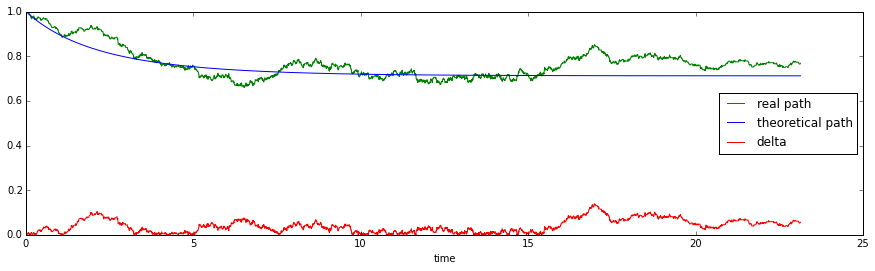

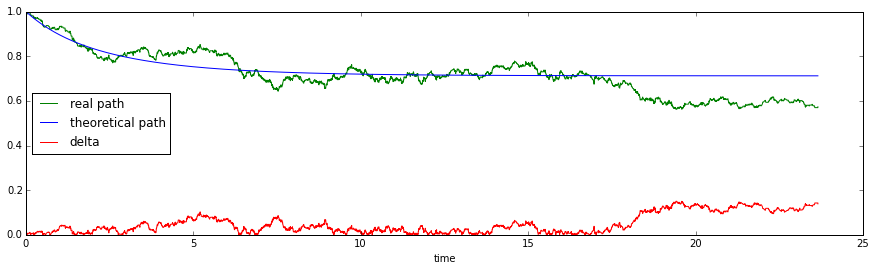

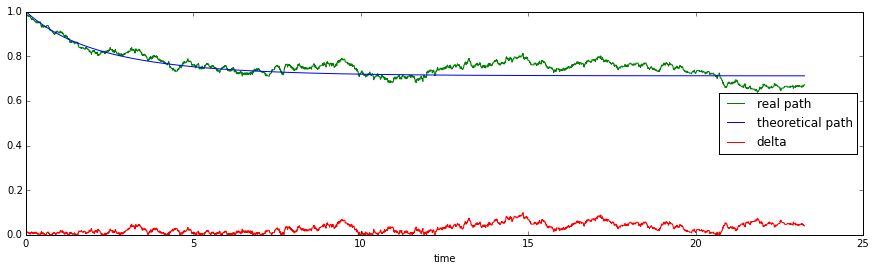

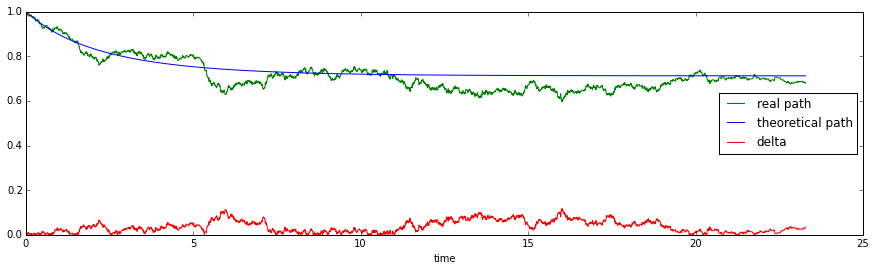

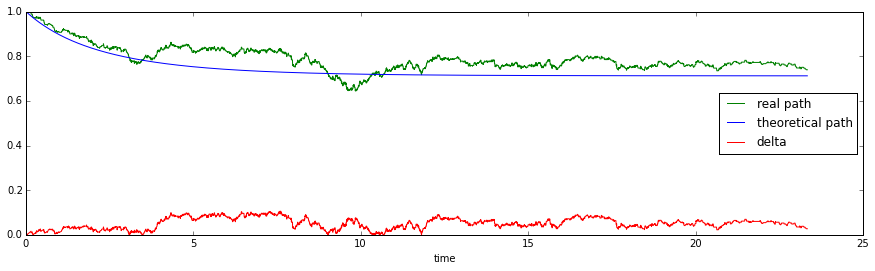

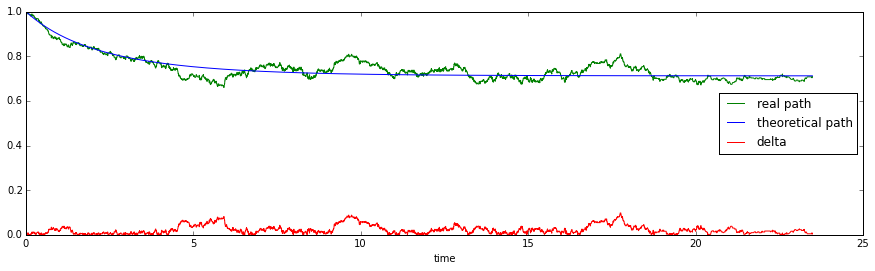

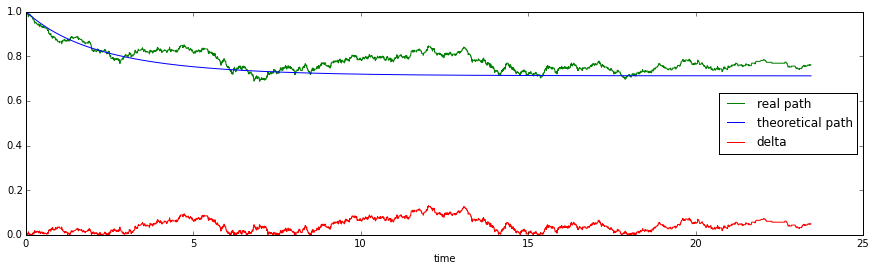

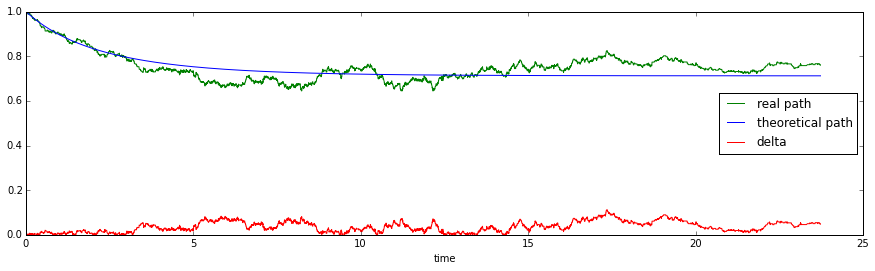

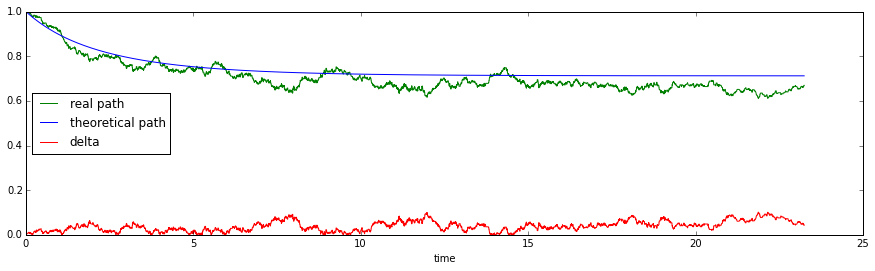

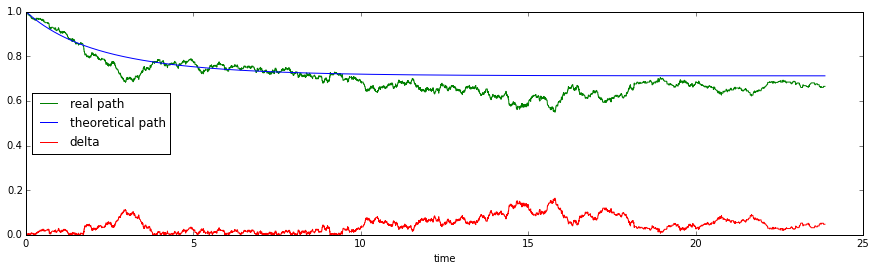

In [113]:
SIZE = 500
GTYPE = 'pois'
queue_size = 10000

def cdf(delta_utility):
    return snorm.cdf(delta_utility, loc=0.0, scale=100)
def get_vertex_degree():
    if GTYPE == 'pois':
        return pois.rvs(SIZE*0.3, 0, 1)[0]
    if GTYPE == 'randint':
        return np.random.randint(10)
    if GTYPE == 'zipf':
        return zipf_distr.rvs(2.5, loc=0, size=1, random_state=None)[0]

final_res_before = []
final_res_after = []

for temp in range(1):
    g, _ = gen_graph()
    g_copy = cp(g)
    res_before = []
    res_after = []
    for k in range(10):
        g = cp(g_copy)
        queue, times = get_queue(queue_size, SIZE)
        for i in range(len(queue)):
            revise_label(queue[i], times[i], g, SIZE, cdf)
        a_t = np.array(g.graph_properties["times"])

        real_path = np.array(g.graph_properties["m_w"])

        g = g_copy
        sol = integr.odeint(derivative_m_w, calc_start_m_w(), a_t)
        deltas = [abs(sol[i][0]-real_path[i]) for i in range(len(sol))]

        stable_i = 0
        smoothed = [1]*1000 + list([abs(np.mean(real_path[i:i+1000]) - np.mean(real_path[-1000:])) for i in range(len(real_path) - 1000)])
        for i in range(len(real_path)-1, 1000, -1):
            if smoothed[i] > 0.05:
                stable_i = i
                break
        res_before.append(np.mean(deltas[0: stable_i]))
        res_after.append(np.mean(deltas[stable_i:]))
        print "before stable = ", res_before[-1], "after stable = ", res_after[-1]      

        fig = plt.figure(figsize = (15, 4))
        ax = fig.add_subplot(111)
        ax.set_xlabel("time")

        ax.plot(a_t, real_path, color = "green", label="real path")
        ax.plot(a_t, sol, color = "blue", label="theoretical path")
        ax.plot(a_t, deltas, color = "red", label="delta")

        plt.legend(loc='best')
    
    stable_before = []
    stable_after = []
    for i in range(len(res_before)):
        if res_after[i] < 1:
            stable_before.append(res_before[i])
            stable_after.append(res_after[i])
    if (len(stable_before) > 0) :
        final_res_before.append(np.mean(stable_before))
        final_res_after.append(np.mean(stable_after))
    print "report: ", len(stable_before), np.mean(stable_before), np.mean(stable_after)
if (len(final_res_after) > 0):
    print "final report: mean error before=", np.mean(final_res_before), "std =", np.std(final_res_before) 
    print "final report: mean error after =", np.mean(final_res_after), "std =", np.std(final_res_after)
    
    
    
    